In [140]:
import pandas as pd
import numpy as np
import mlflow
import matplotlib.pyplot as plt
import warnings
import statsmodels.api as sm

from statsmodels.tsa.api import SimpleExpSmoothing, Holt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse
from pmdarima.arima import auto_arima, AutoARIMA
from prophet import Prophet

%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
# Read in the data
df = pd.read_csv('../data/data_daily.csv')

In [4]:
# Convert the date column to datetime
df.columns = ['date', 'receipt_count']
df['date'] = pd.to_datetime(df['date'])

In [5]:
df.head()

date  receipt_count
0 2021-01-01        7564766
1 2021-01-02        7455524
2 2021-01-03        7095414
3 2021-01-04        7666163
4 2021-01-05        7771289

In [49]:
def split_data(df):
    """
    Splits the data into train and test sets.
    Jan-Oct 2021 is the train set.
    Nov-Dec 2021 is the test set.
    """
    train = df.iloc[:-61]
    test = df.iloc[-61:]
    return train, test

In [87]:
def plot_predictions(train, test, predictions, col):
    fig = plt.figure(figsize=(15,4))
    plt.plot(train.receipt_count, label='Train')
    plt.plot(test.receipt_count, label='Test')
    plt.plot(predictions[col], label='yhat')
    plt.legend(loc='best')
    plt.show()
    return fig

In [74]:
mlflow.set_tracking_uri('sqlite:///../mlflow.db')

## Naive Baseline Model

Predicting the next day's receipt count to be the same as the current day's receipt count.

Naive RMSE:  503643.9113116317


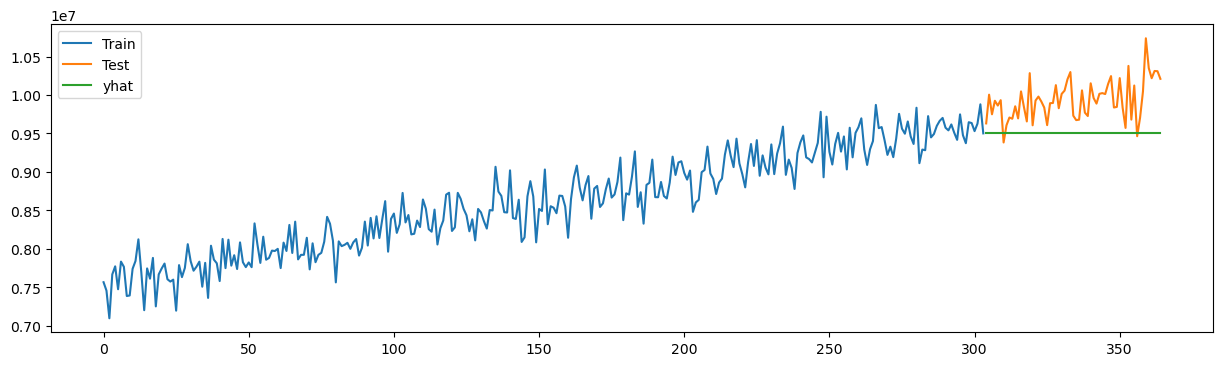

In [86]:
# Split the data
naive_train, naive_test = split_data(df)

mlflow.set_experiment('baseline-naive-forecast')

with mlflow.start_run():
    # Create a naive forecast
    naive_forecast = naive_train.iloc[-1]['receipt_count']

    # Create a list of naive forecasts
    naive_yhat = [naive_forecast] * len(naive_test)

    # Calculate the RMSE
    naive_rmse = rmse(naive_test['receipt_count'], naive_yhat)
    print('Naive RMSE: ', naive_rmse)

    fig = plt.figure(figsize=(15,4))
    plt.plot(naive_train.receipt_count, label='Train')
    plt.plot(naive_test.receipt_count, label='Test')
    plt.plot(pd.Series(naive_yhat, index=range(304,365)), label='yhat')
    plt.legend(loc='best')
    plt.show()

    # Log the RMSE
    mlflow.log_metric('rmse', naive_rmse)
    mlflow.log_param('model', 'naive-model')
    mlflow.log_figure(fig, 'naive_model_results.png')

## Simple Exponential Smoothing

In [58]:
ses_train, ses_test = split_data(df)

In [234]:
mlflow.set_experiment('exponential-smoothing-models')

<Experiment: artifact_location='/Users/wizard/Astronaut/Assesments/Fetch_Rewards/notebooks/mlruns/2', creation_time=1697662998280, experiment_id='2', last_update_time=1697662998280, lifecycle_stage='active', name='exponential-smoothing-models', tags={}>

SES RMSE:  428077.9220318768


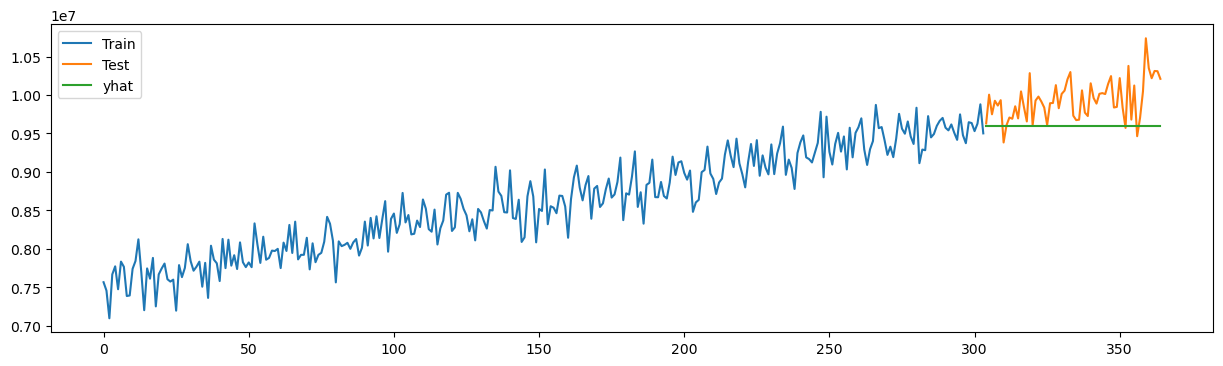

In [90]:
with mlflow.start_run():
    ses_model = SimpleExpSmoothing(np.asarray(ses_train.receipt_count)).fit()
    ses_test['SES'] = ses_model.forecast(len(ses_test))

    # Calculate the RMSE
    ses_rmse = rmse(ses_test['receipt_count'], ses_test['SES'])
    print('SES RMSE: ', ses_rmse)

    plot_predictions(ses_train, ses_test, ses_test, 'SES')

    # Log the RMSE
    mlflow.log_metric('rmse', ses_rmse)
    mlflow.log_param('model', 'simple-exponential-smoothing')
    mlflow.log_figure(fig, 'ses_model_results.png')

## Holt’s Linear Trend method

In [92]:
hlt_train, hlt_test = split_data(df)

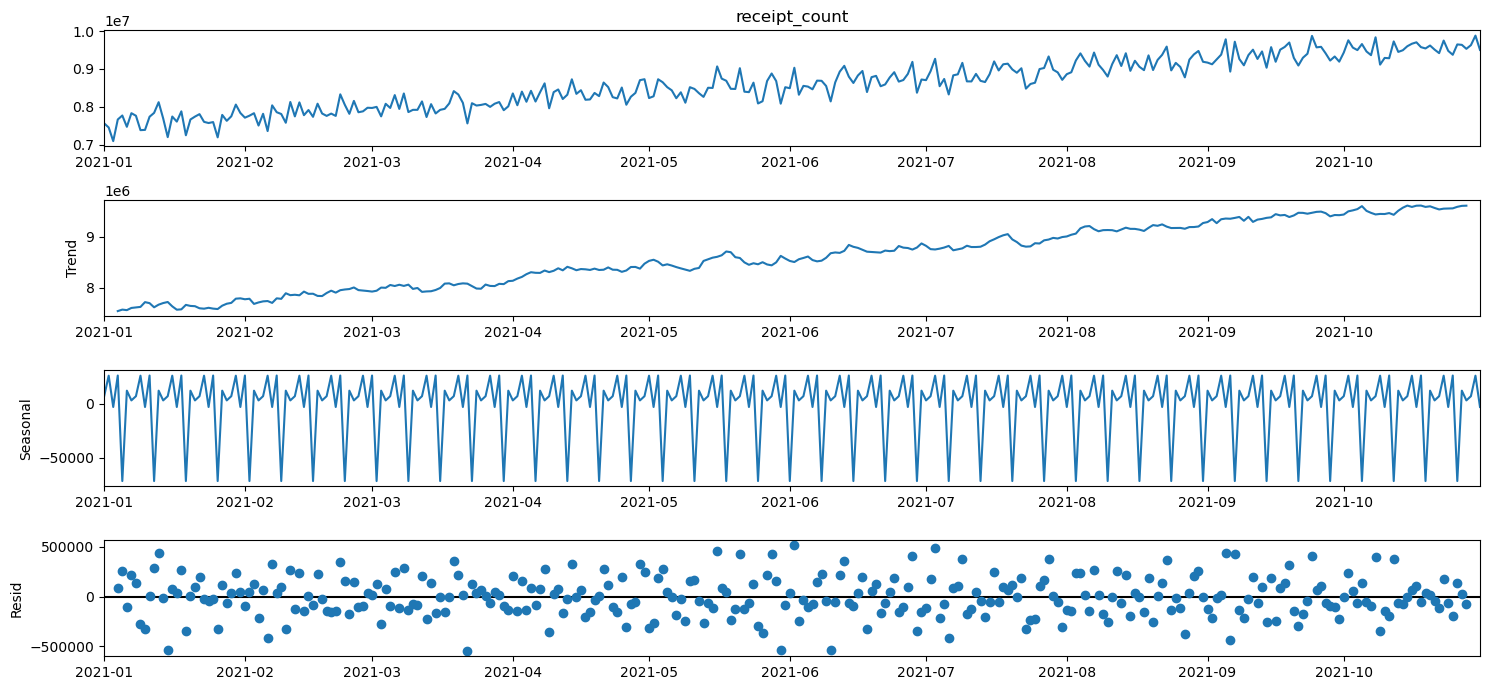

In [111]:
fig = sm.tsa.seasonal_decompose(hlt_train.set_index('date').receipt_count).plot()
fig.set_size_inches((15, 7))
plt.tight_layout()
plt.show()

HLT RMSE:  245366.56376077837


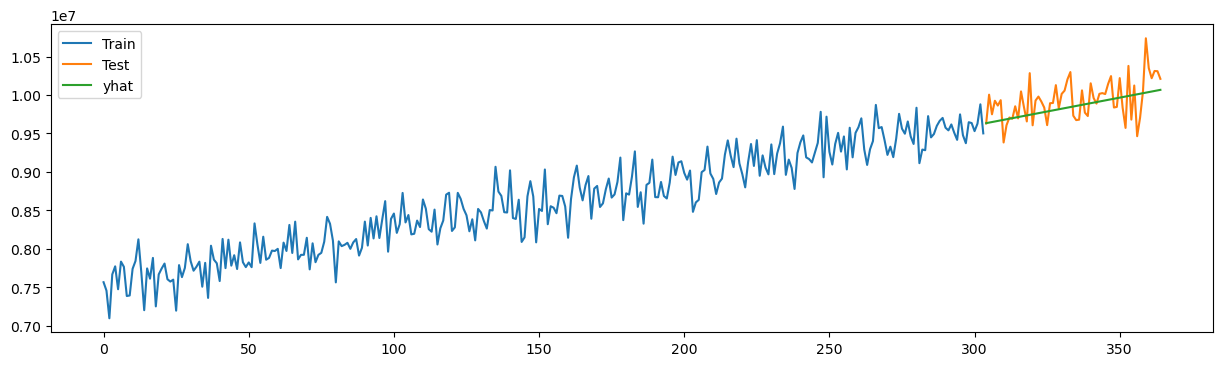

In [114]:
with mlflow.start_run():
    hlt_model = Holt(np.asarray(hlt_train.receipt_count)).fit()
    hlt_test['HLT'] = hlt_model.forecast(len(hlt_test))

    # Calculate the RMSE
    hlt_rmse = rmse(hlt_test['receipt_count'], hlt_test['HLT'])
    print('HLT RMSE: ', hlt_rmse)

    plot_predictions(hlt_train, hlt_test, hlt_test, 'HLT')

    # Log the RMSE
    mlflow.log_metric('rmse', hlt_rmse)
    mlflow.log_param('model', 'holt-linear-trend')
    mlflow.log_figure(fig, 'hlt_model_results.png')

## Holt-Winters Method

In [240]:
hw_train, hw_test = split_data(df)

HW RMSE:  428077.9220318768


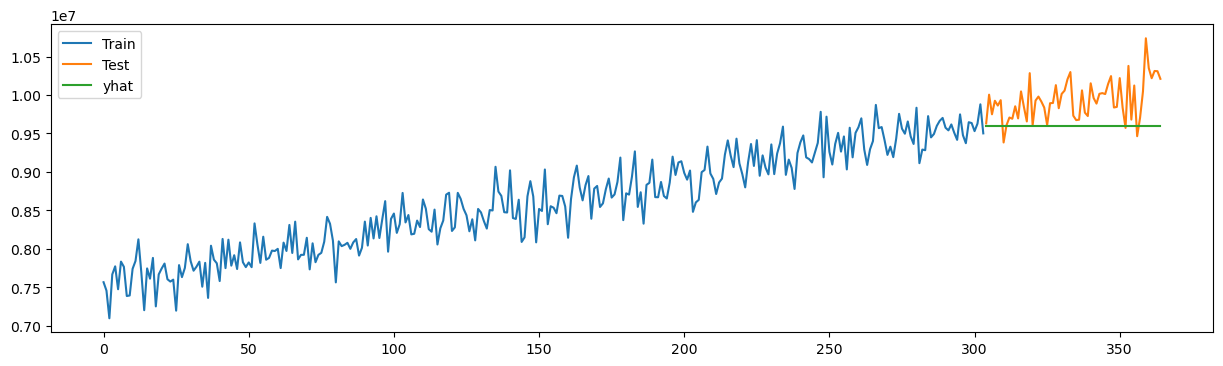

In [130]:
with mlflow.start_run():
    hw_model = ExponentialSmoothing(np.asarray(hw_train.receipt_count)).fit()
    hw_test['hw'] = hw_model.forecast(len(hw_test))

    # Calculate the RMSE
    hw_rmse = rmse(hw_test['receipt_count'], hw_test['hw'])
    print('HW RMSE: ', hw_rmse)

    plot_predictions(hw_train, hw_test, hw_test, 'hw')

    # Log the RMSE
    mlflow.log_metric('rmse', hw_rmse)
    mlflow.log_param('model', 'holt-winters')
    mlflow.log_figure(fig, 'hw_model_results.png')

HW RMSE:  280654.28578571376


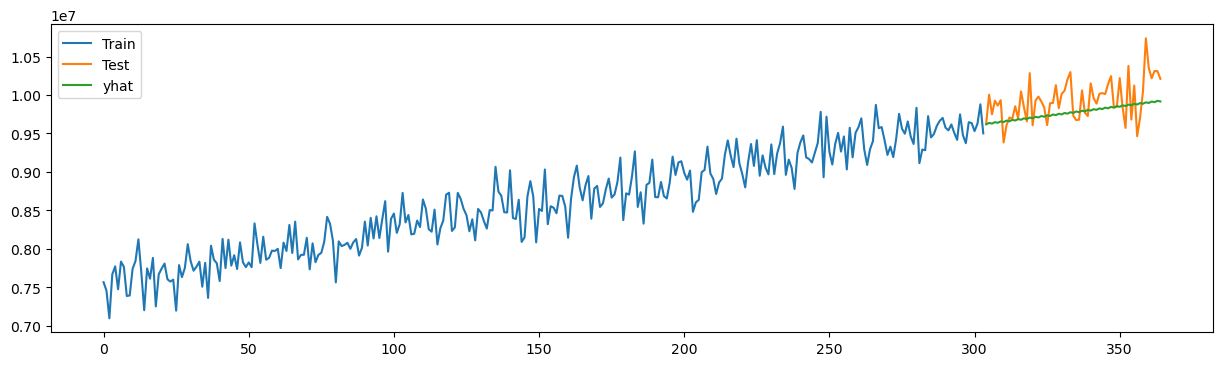

HW RMSE:  280362.10688520723


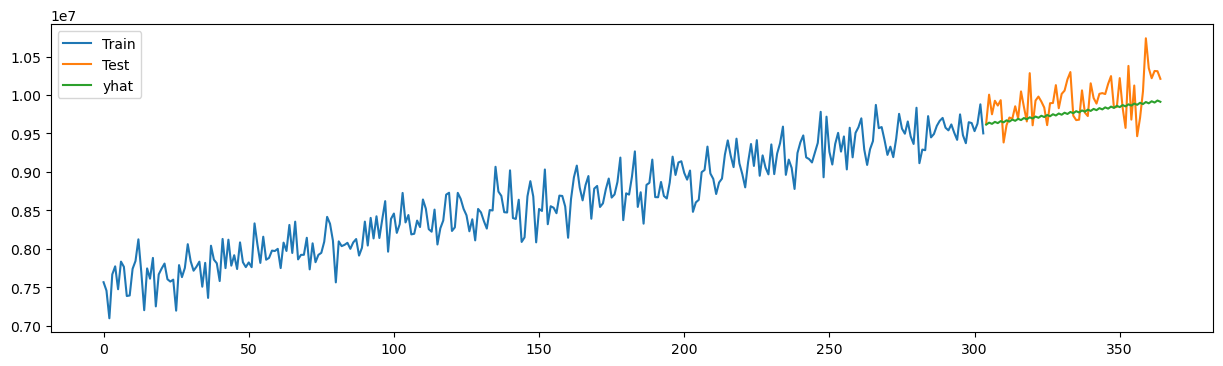

HW RMSE:  237634.82664590626


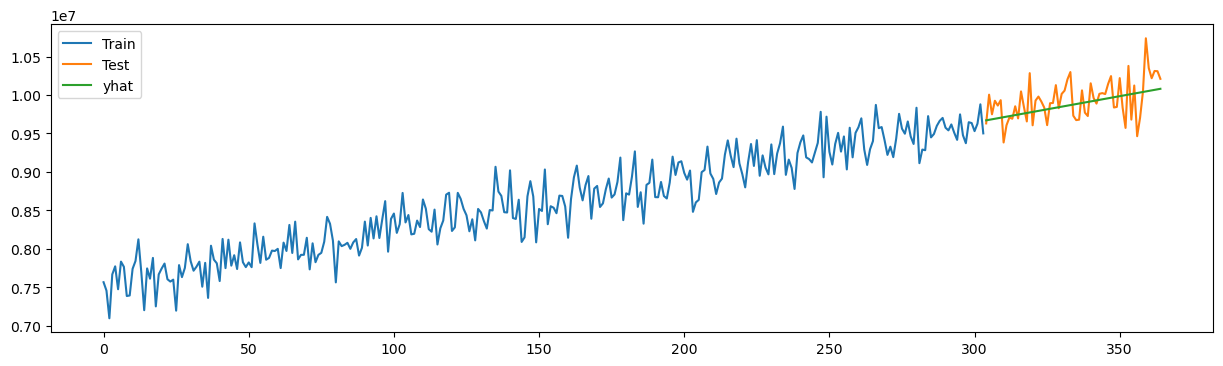

HW RMSE:  284260.63815924345


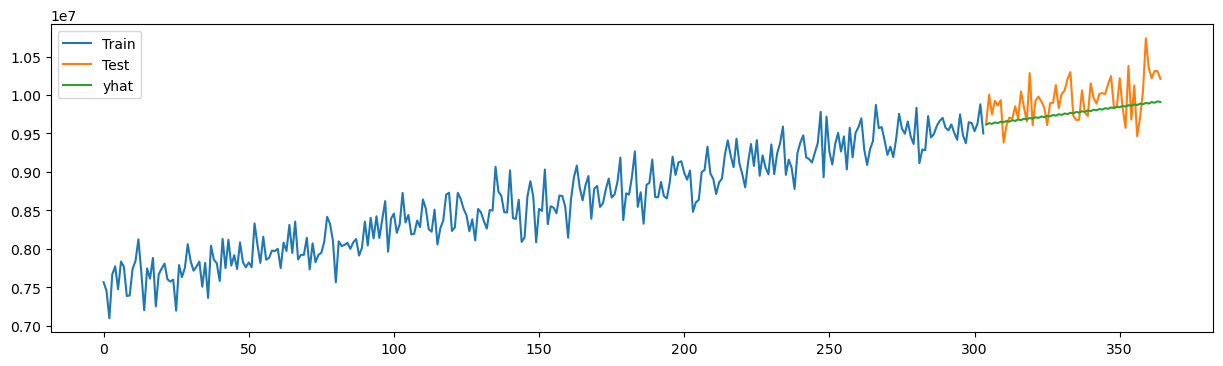

HW RMSE:  284006.39403327147


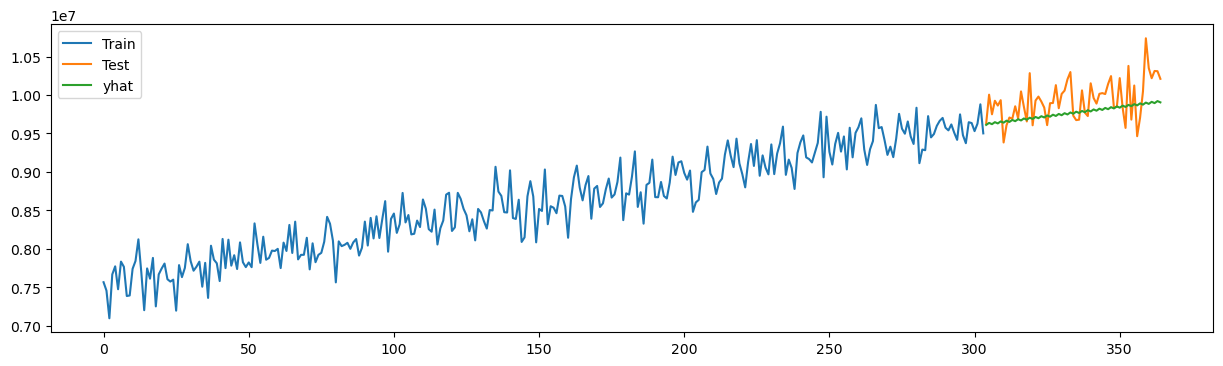

HW RMSE:  233683.43164149037


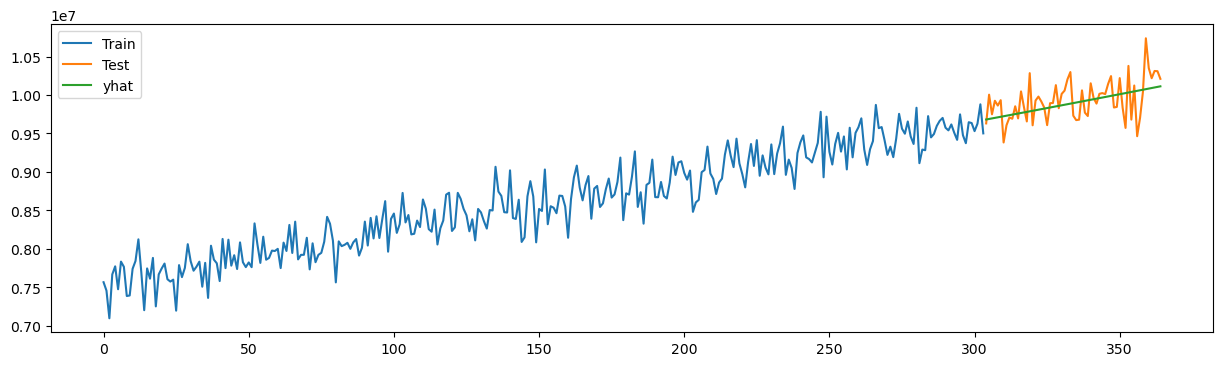

HW RMSE:  427113.7902348447


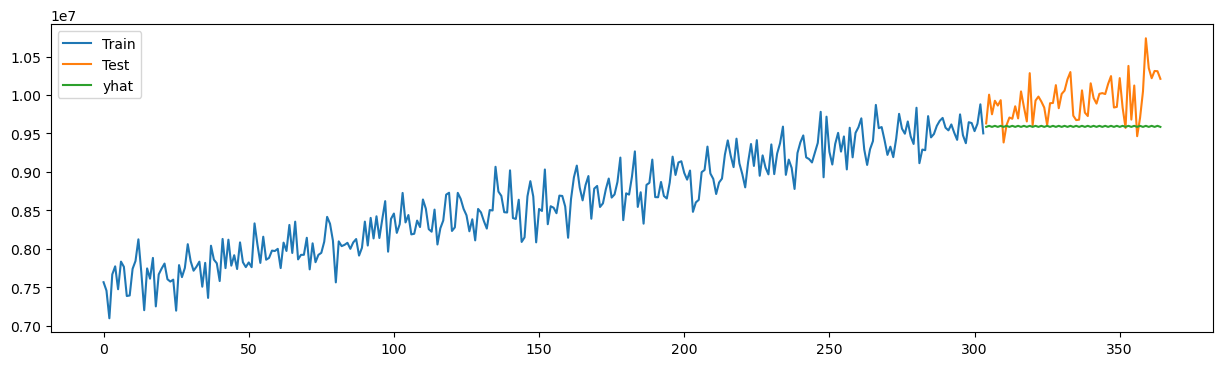

HW RMSE:  427047.2388890116


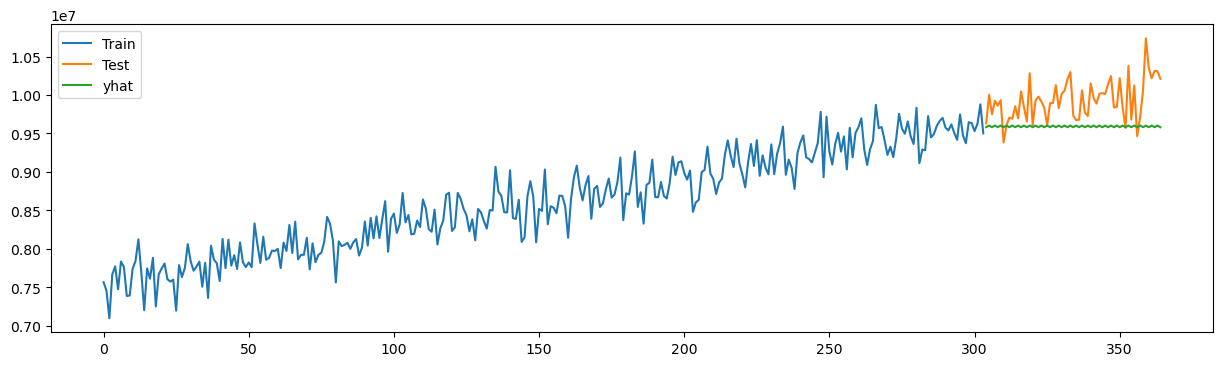

HW RMSE:  428077.9220318768


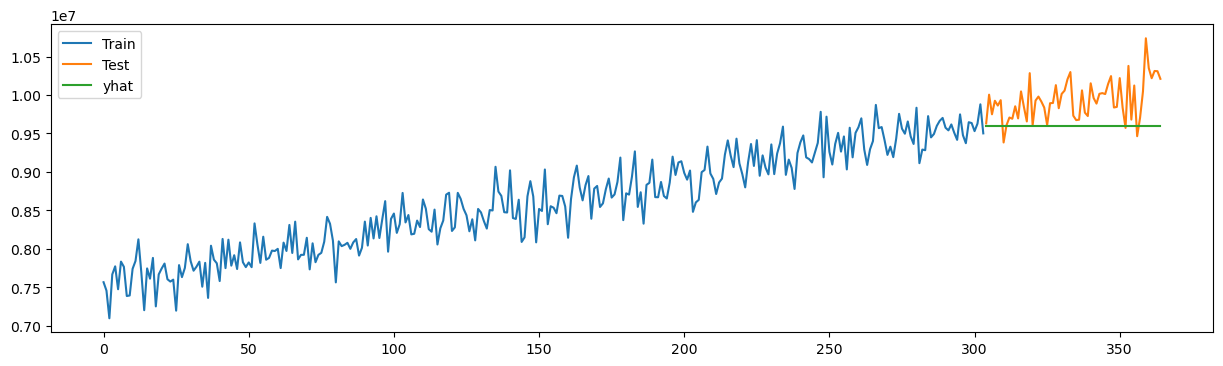

HW RMSE:  265350.0830493199


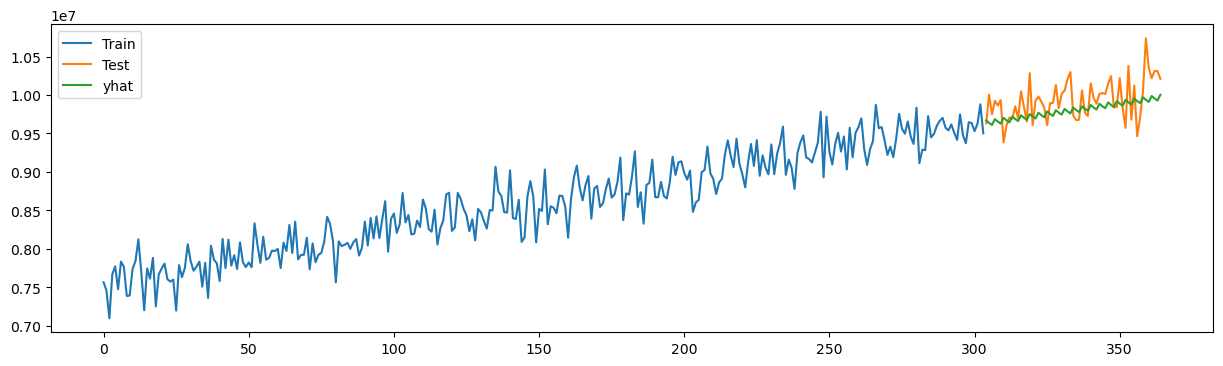

HW RMSE:  265559.19394862046


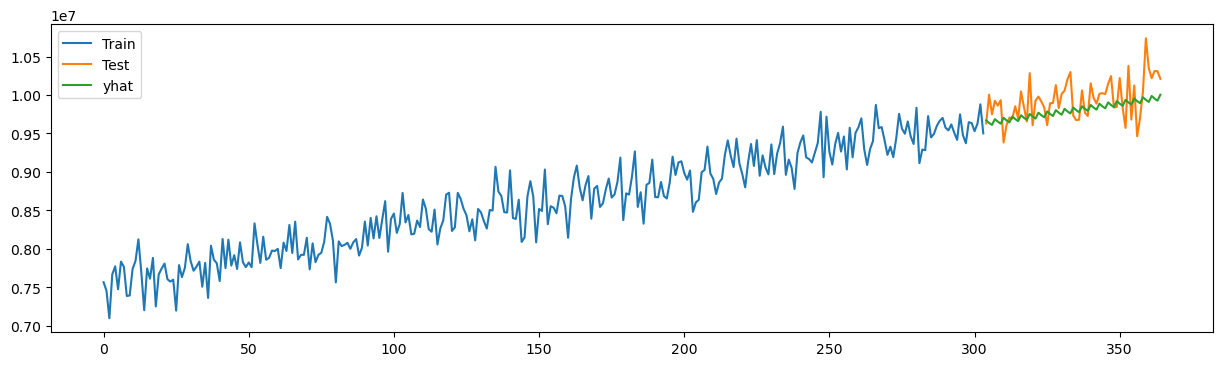

HW RMSE:  237634.82664590626


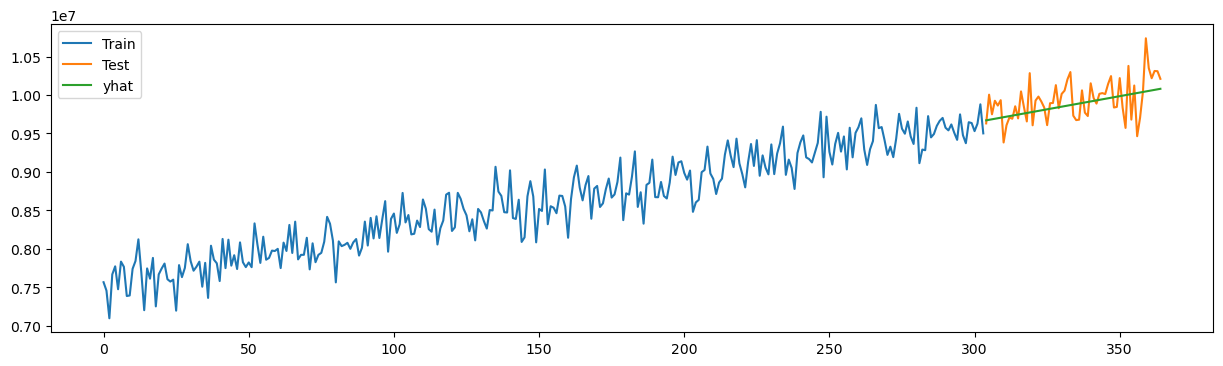

HW RMSE:  262237.19942368305


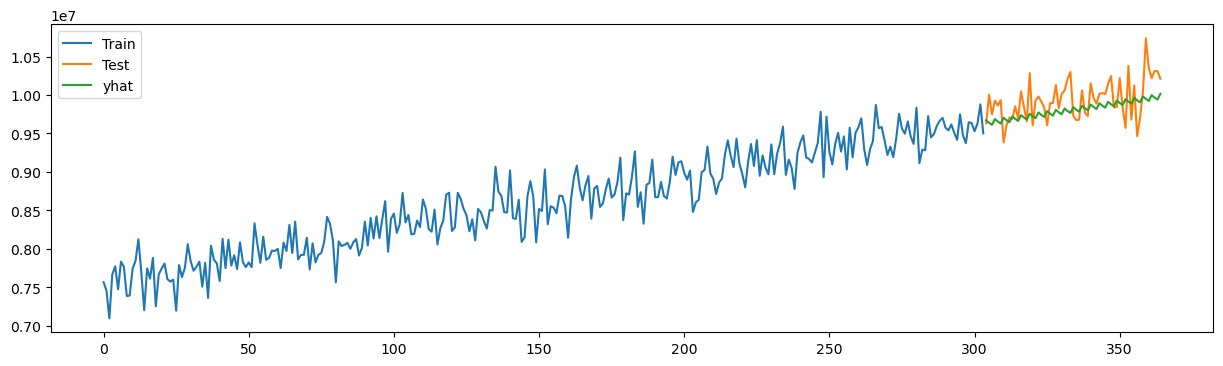

HW RMSE:  648943.0953198443


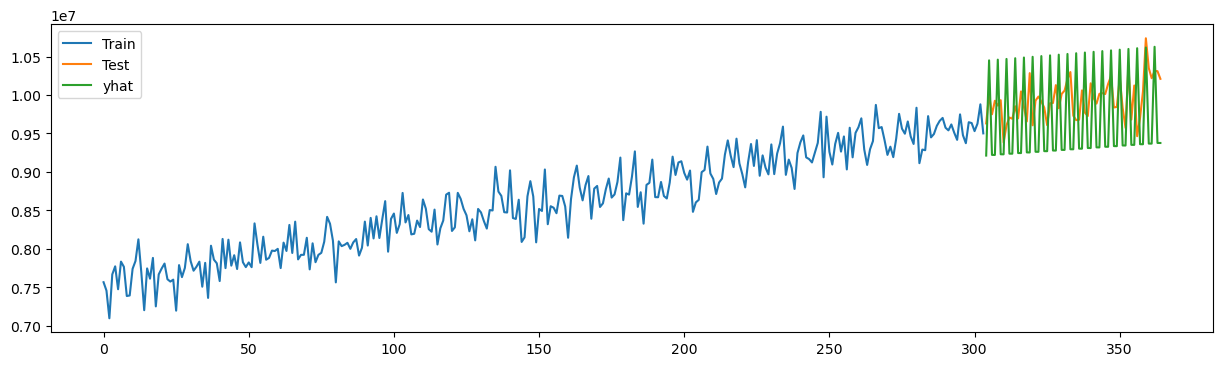

HW RMSE:  233683.43164149037


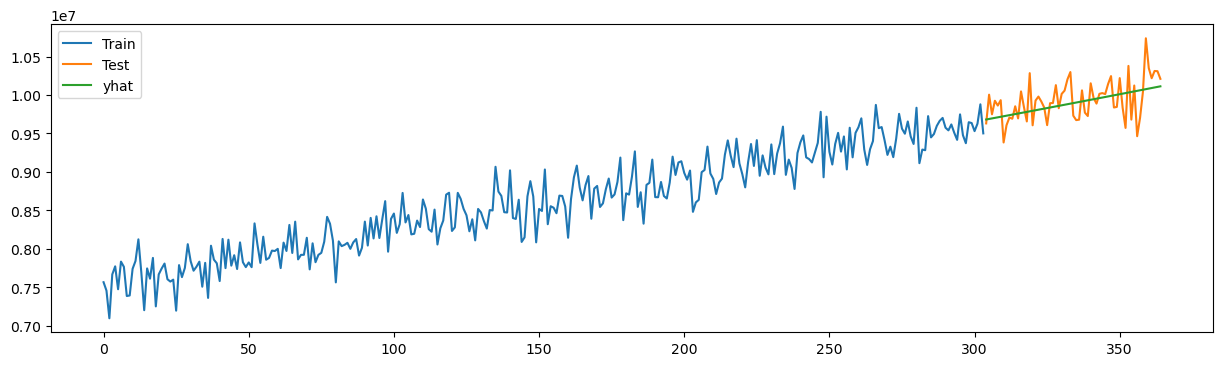

HW RMSE:  421317.77335976326


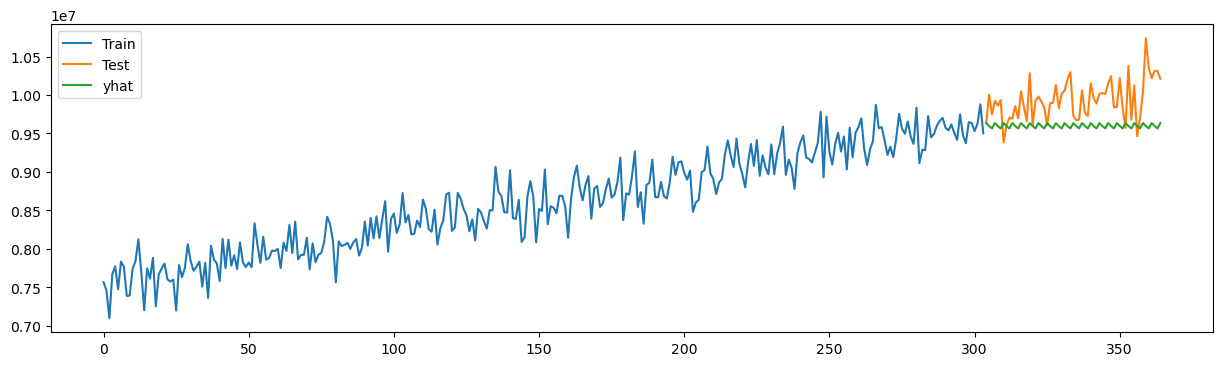

HW RMSE:  421272.4870066404


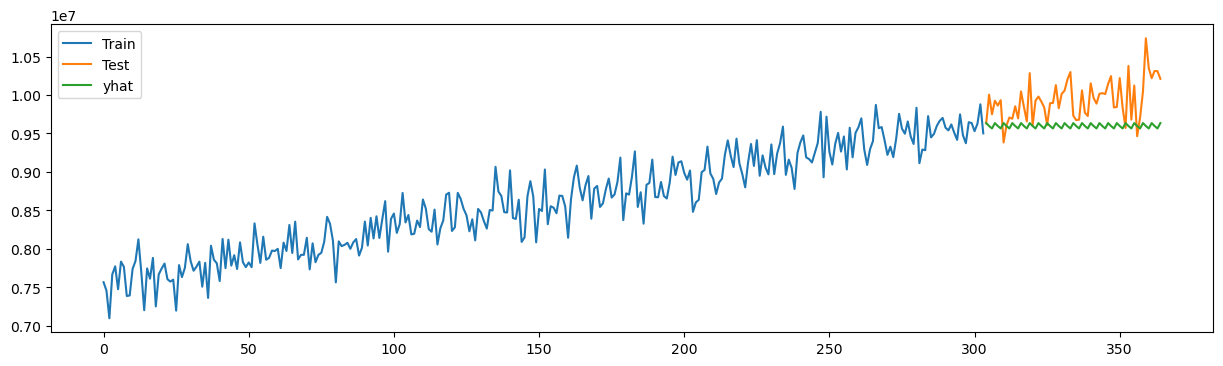

HW RMSE:  428077.9220318768


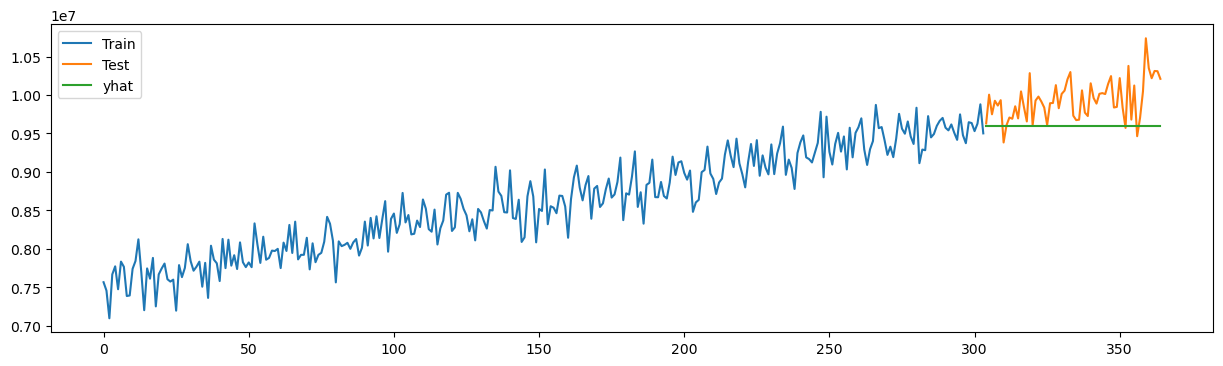

HW RMSE:  277478.21289283683


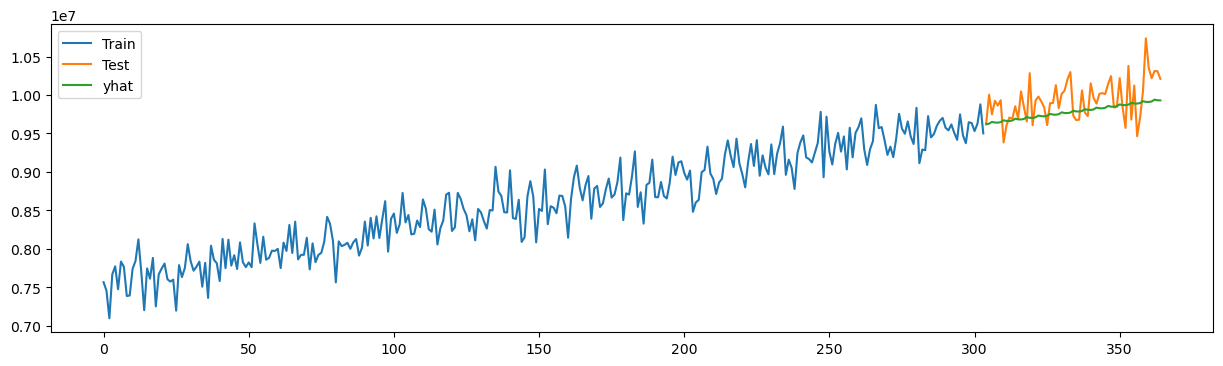

HW RMSE:  277635.39952111134


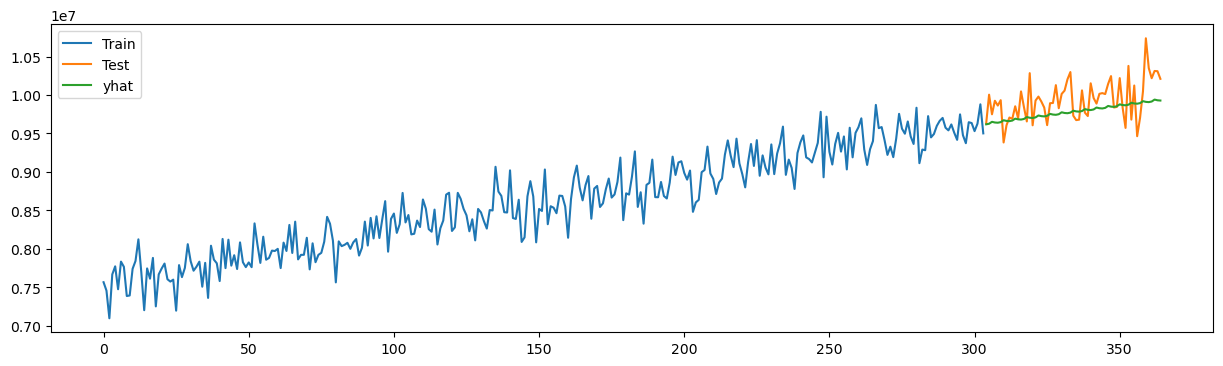

HW RMSE:  237634.82664590626


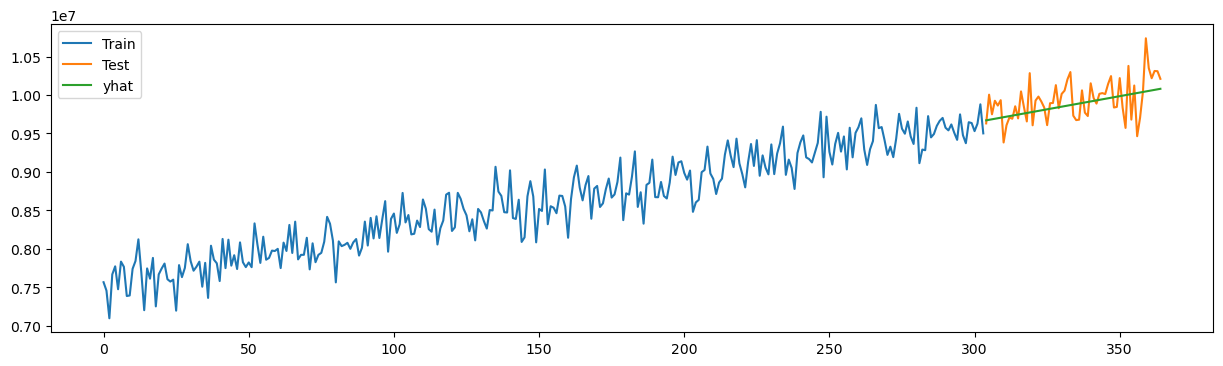

HW RMSE:  275039.0922125148


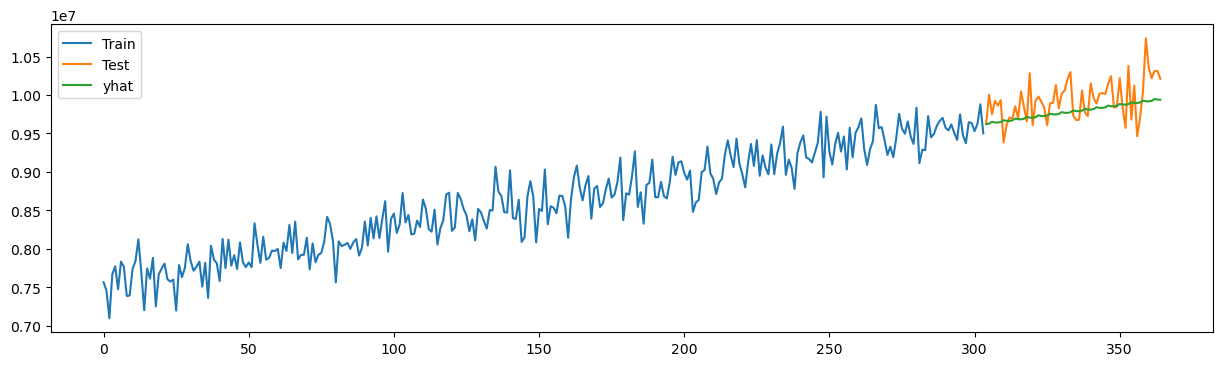

HW RMSE:  275185.9934315748


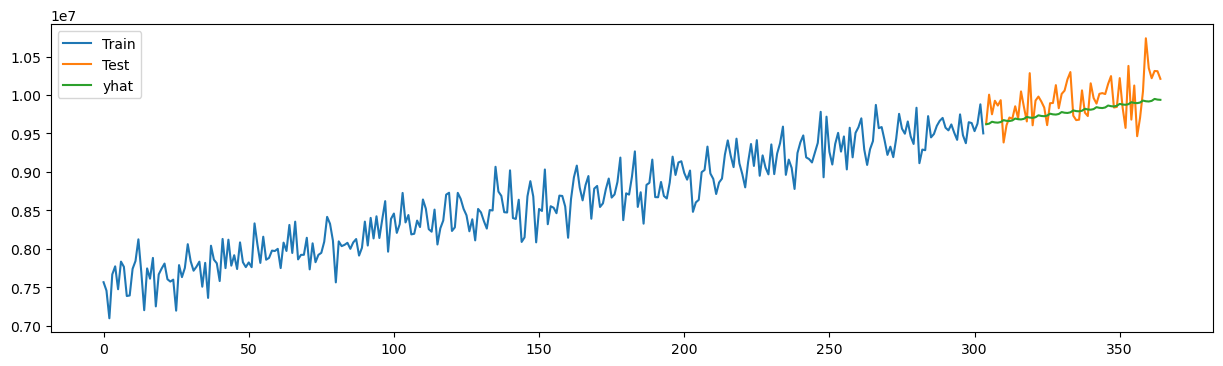

HW RMSE:  233683.43164149037


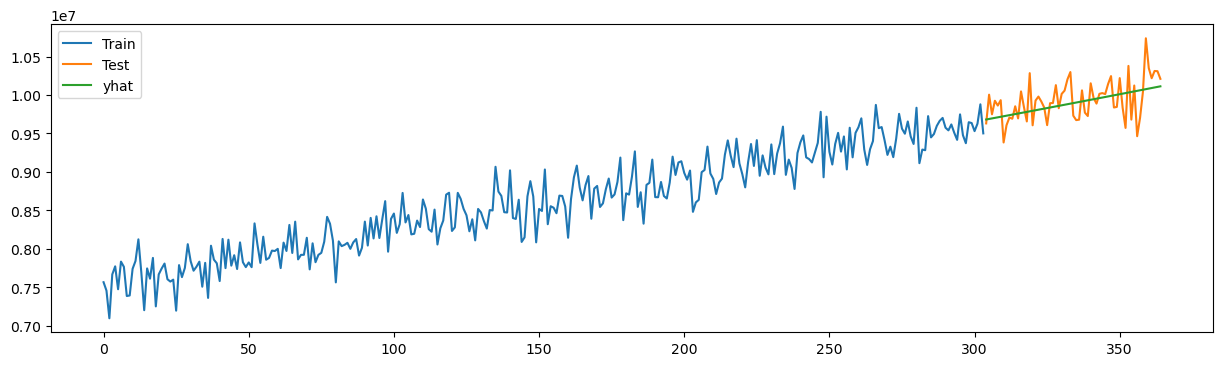

HW RMSE:  427356.9304983477


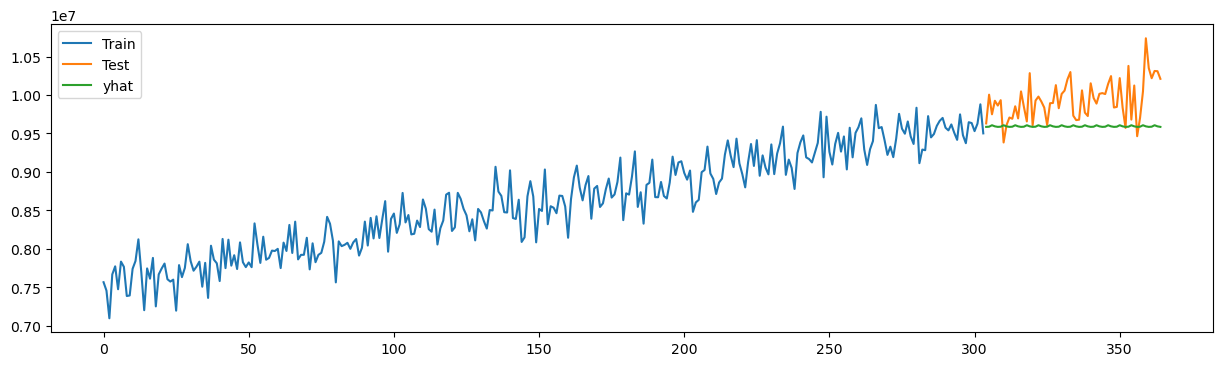

HW RMSE:  427338.92052248376


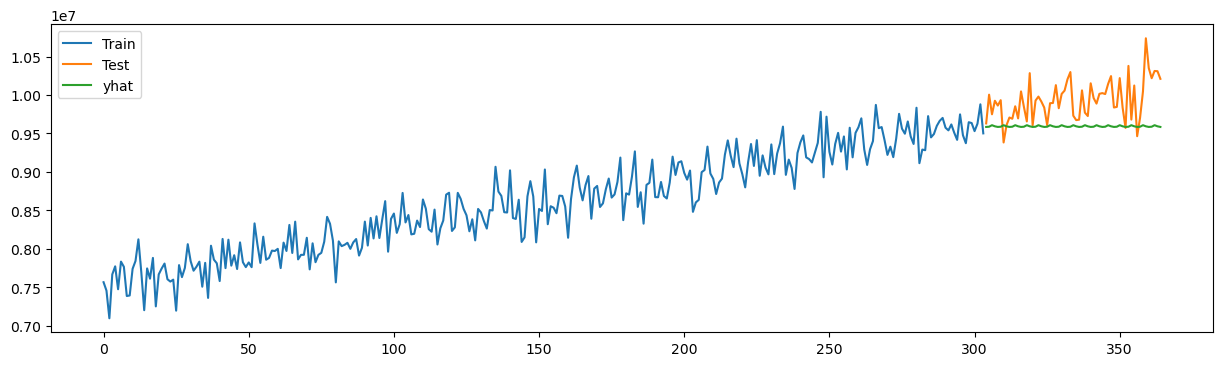

HW RMSE:  428077.9220318768


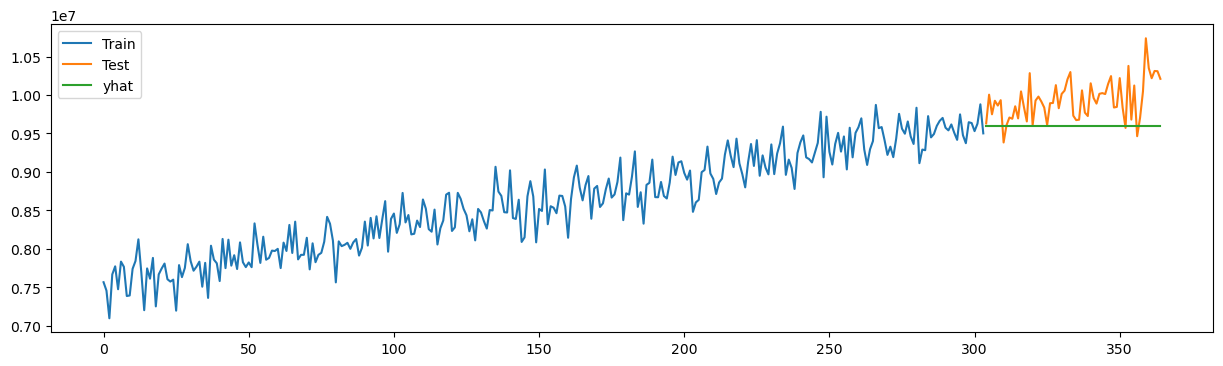

HW RMSE:  272015.3430842876


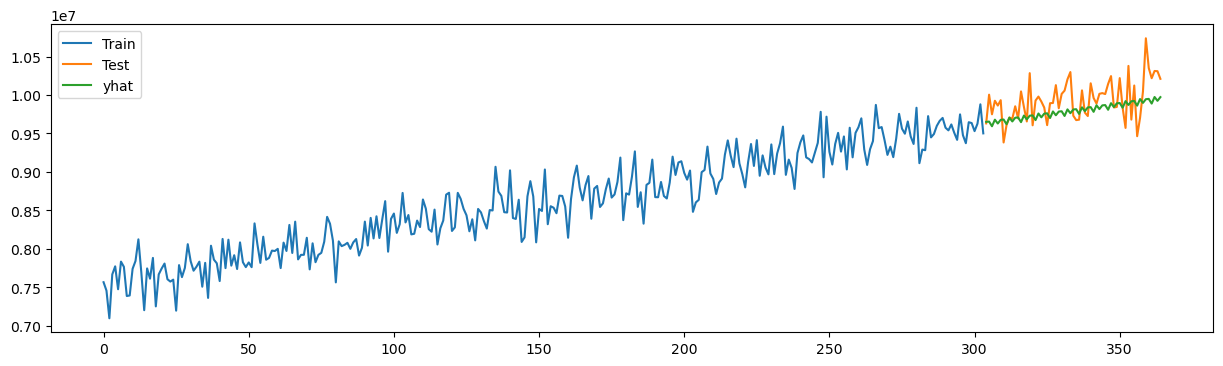

HW RMSE:  272345.193401801


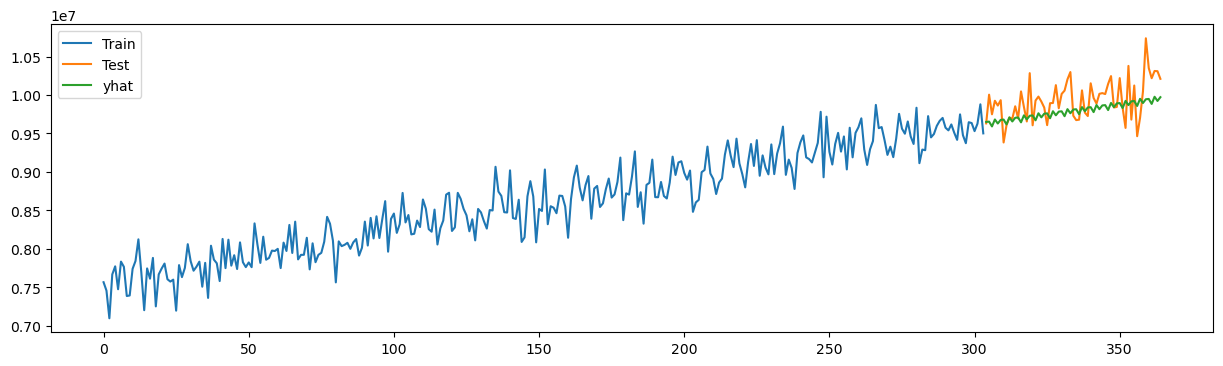

HW RMSE:  237634.82664590626


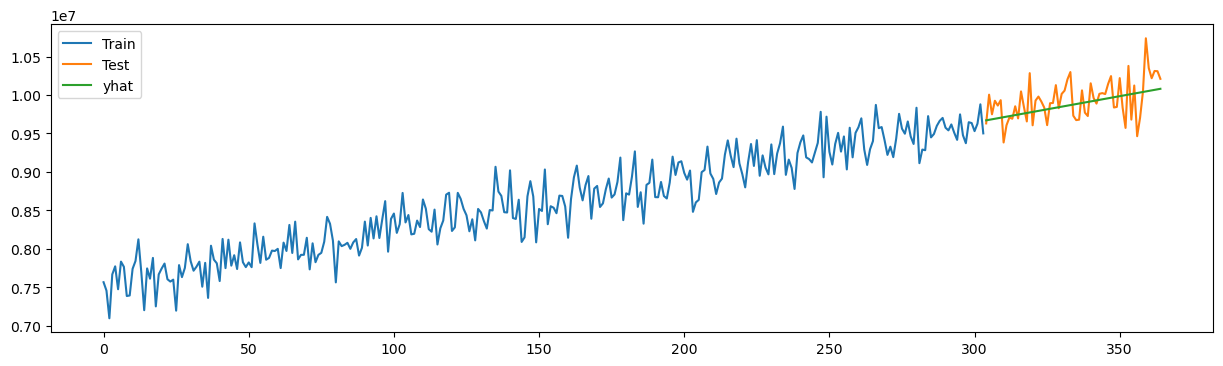

HW RMSE:  274153.69987949025


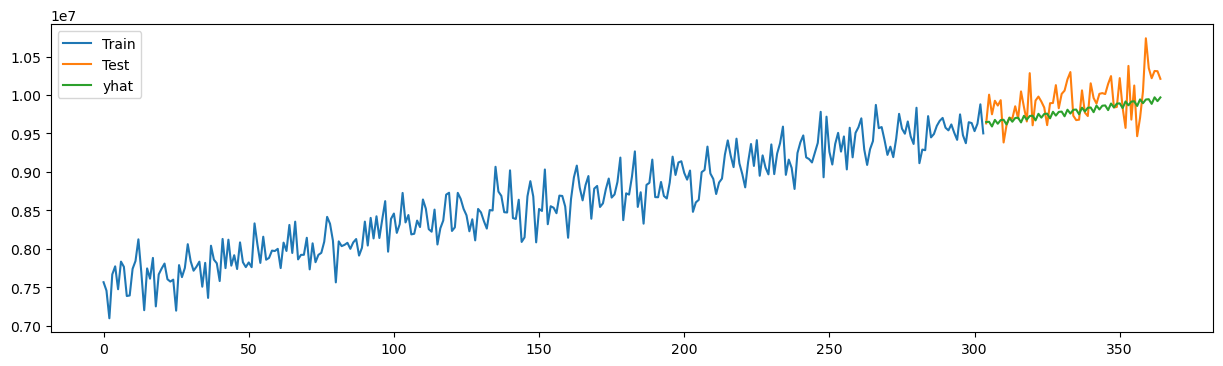

HW RMSE:  274493.93277157546


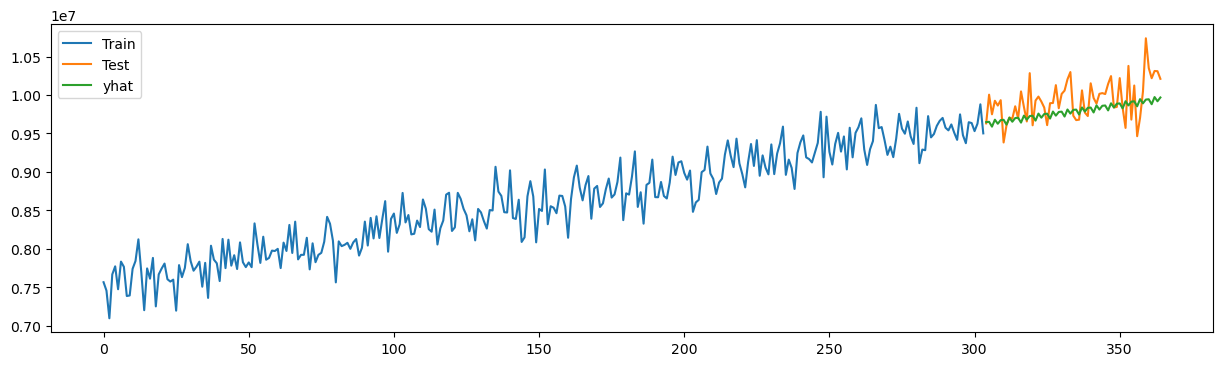

HW RMSE:  233683.43164149037


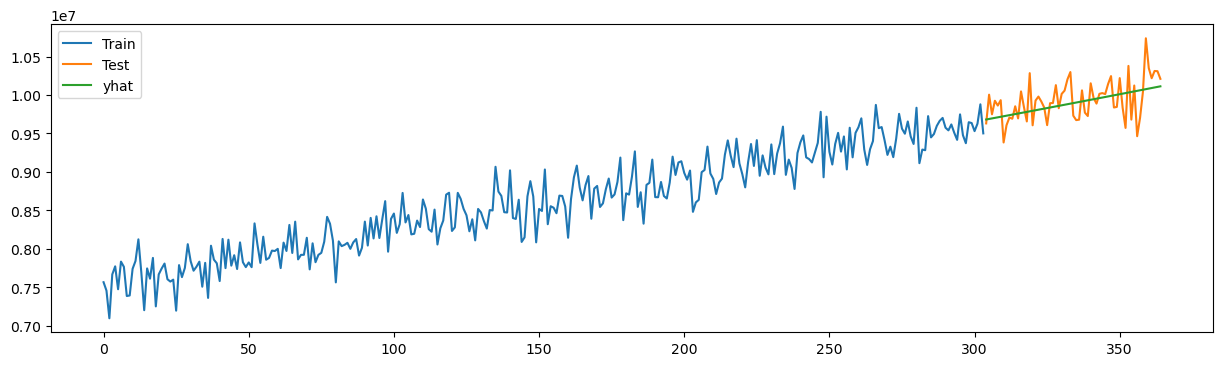

HW RMSE:  426331.5354956526


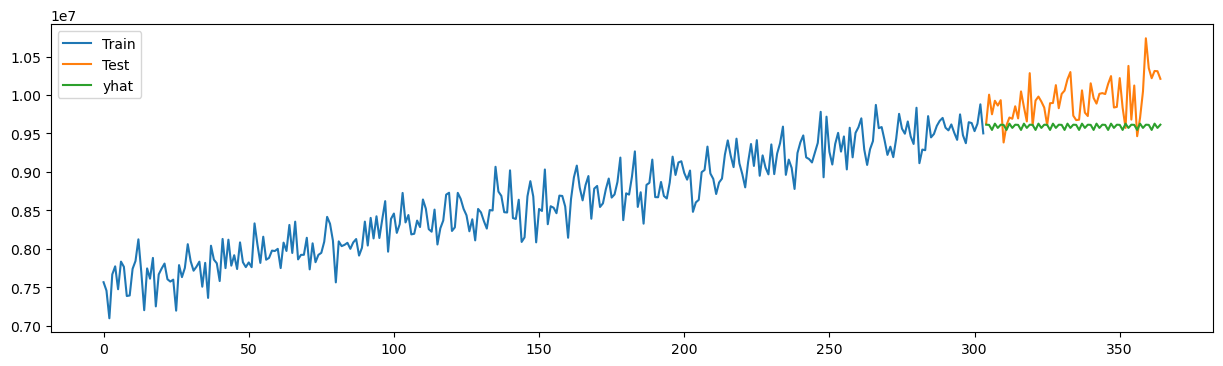

HW RMSE:  426377.0942152322


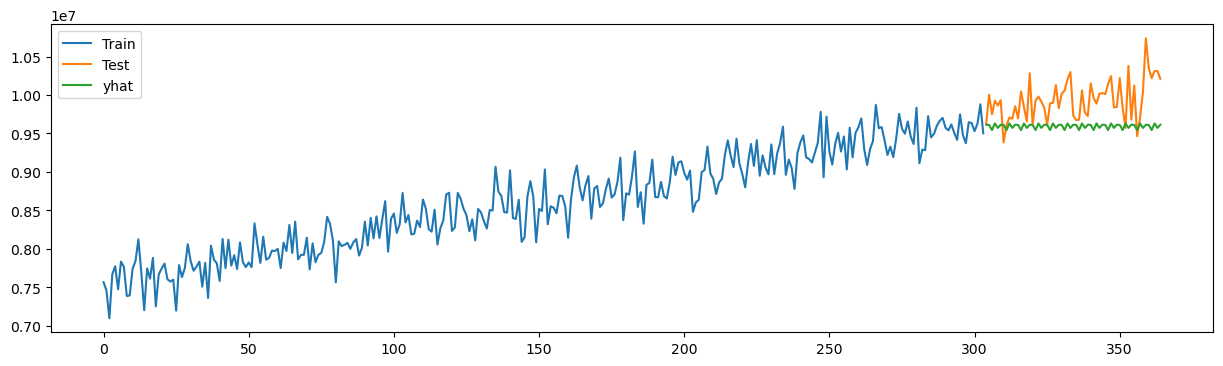

HW RMSE:  428077.9220318768


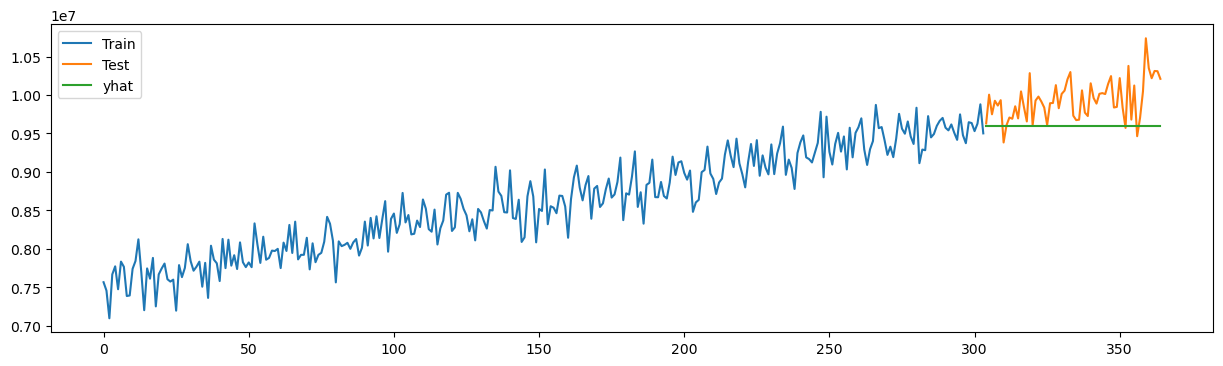

HW RMSE:  271653.0006397026


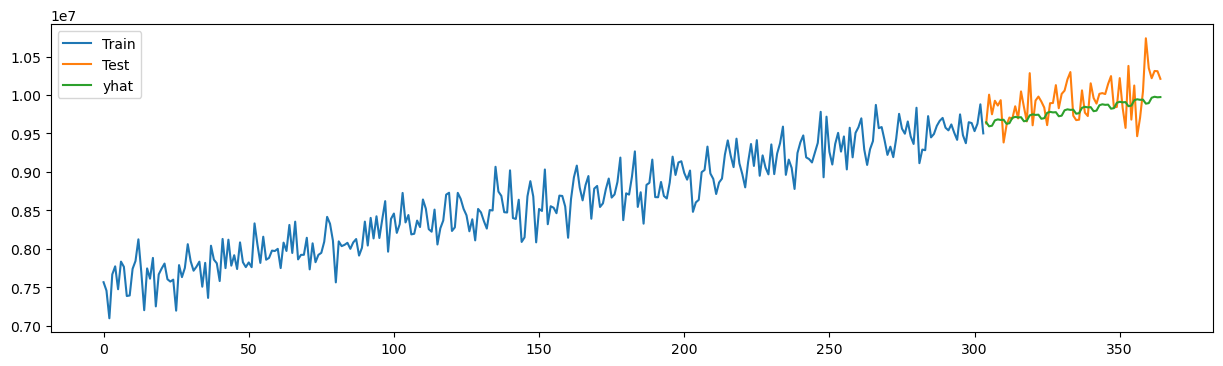

HW RMSE:  271999.890105673


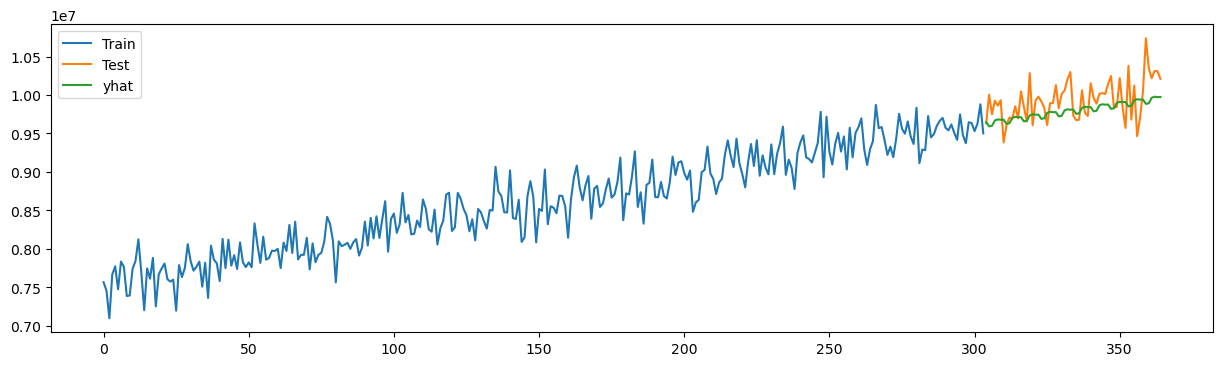

HW RMSE:  237634.82664590626


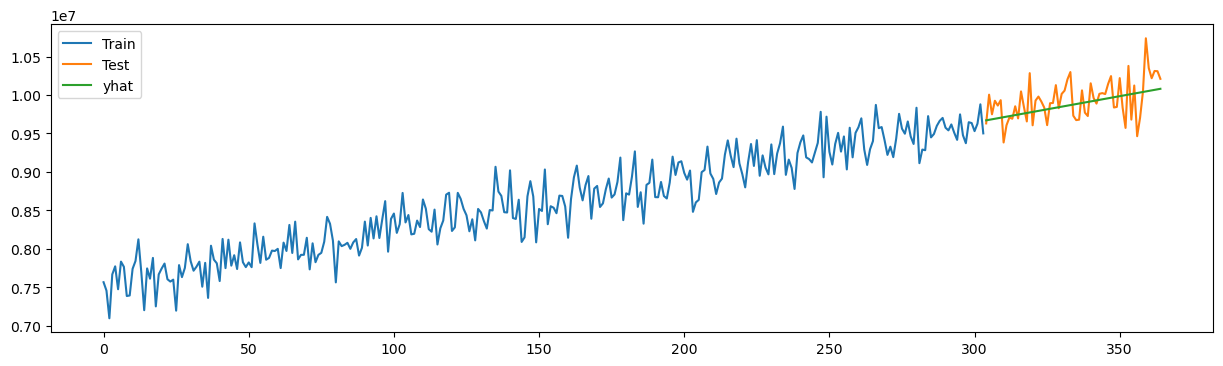

HW RMSE:  268166.60362266726


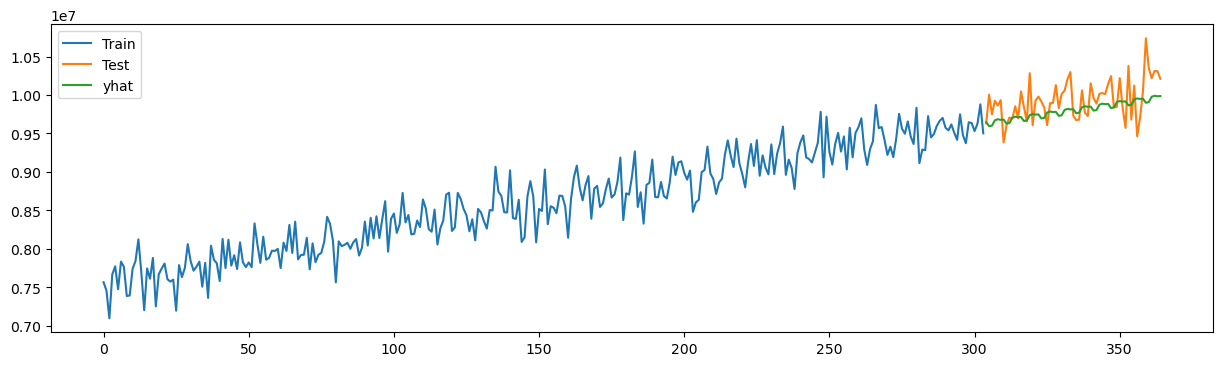

HW RMSE:  268517.78055115044


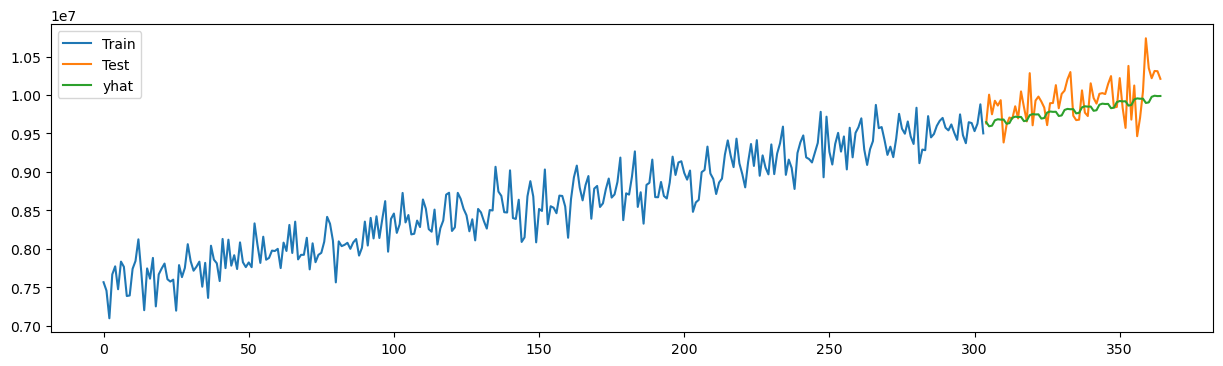

HW RMSE:  233683.43164149037


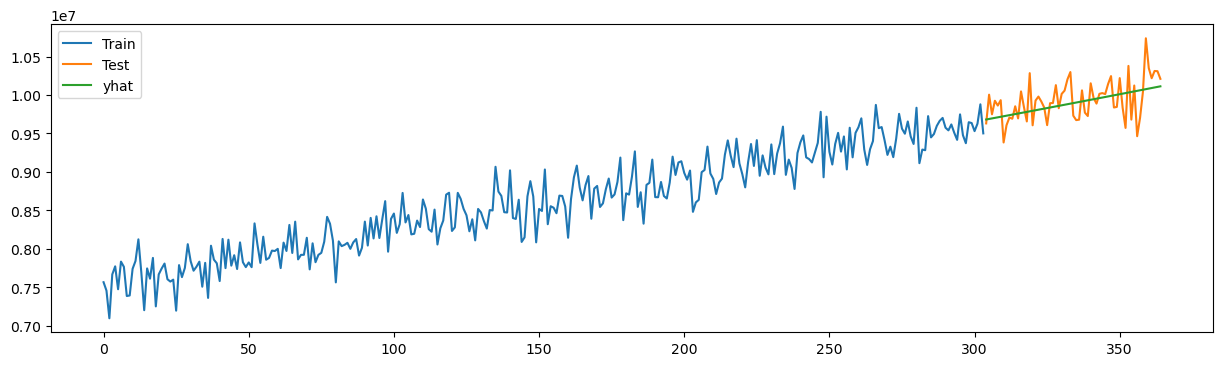

HW RMSE:  432366.42829263624


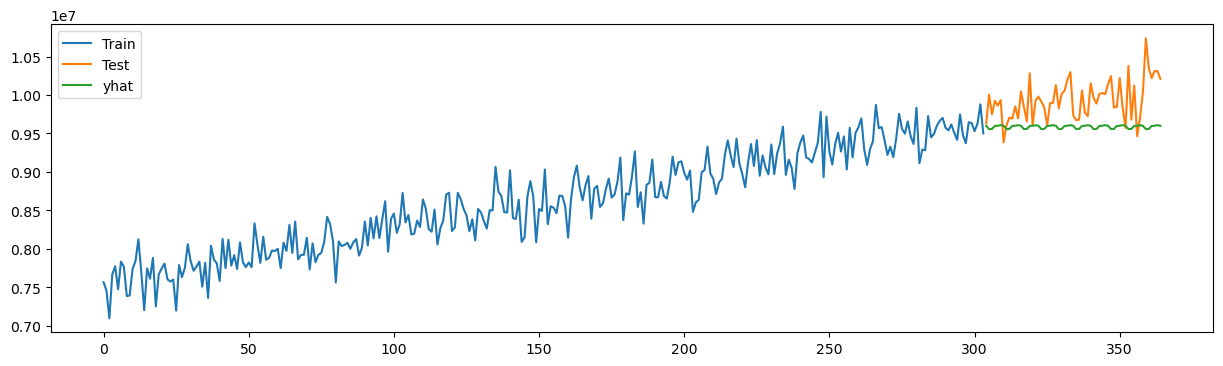

HW RMSE:  431668.3800364586


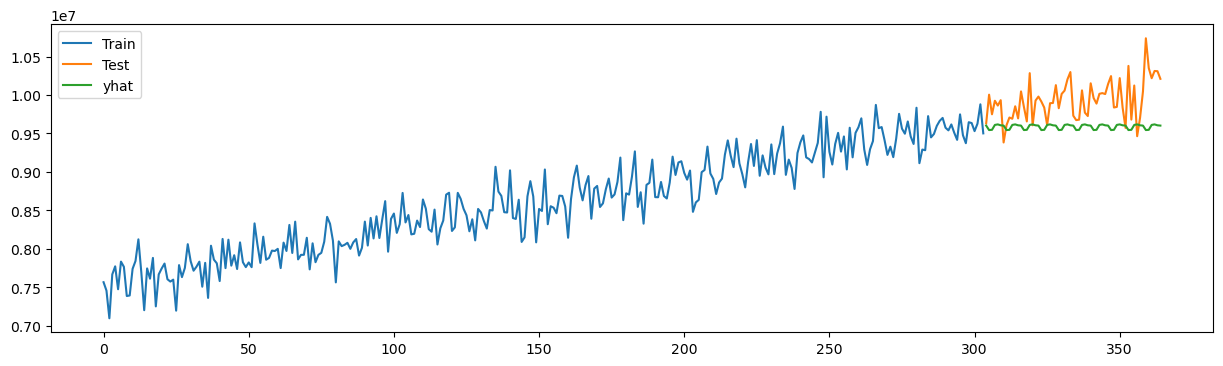

HW RMSE:  428077.9220318768


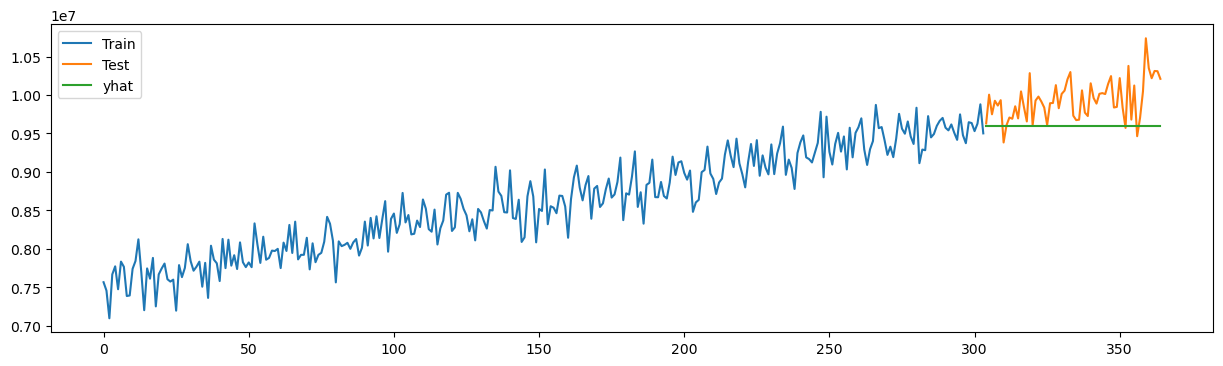

HW RMSE:  260700.40764071673


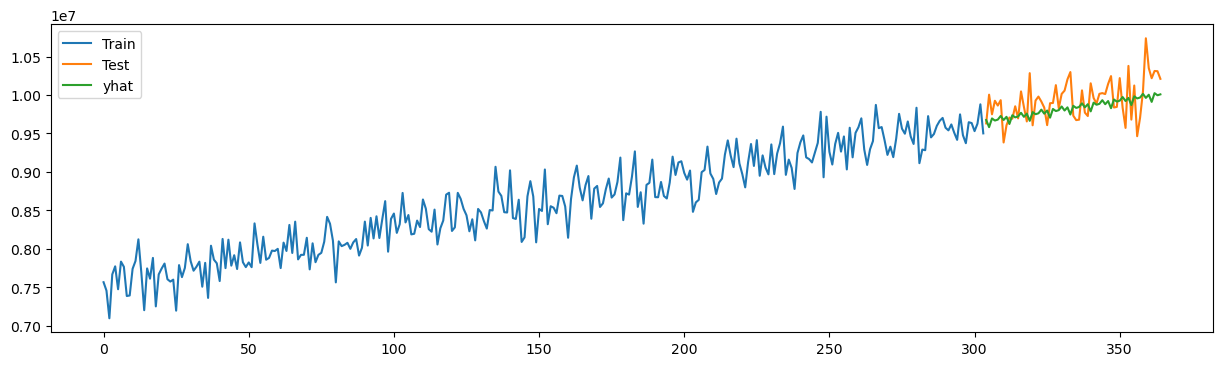

HW RMSE:  262622.8180021509


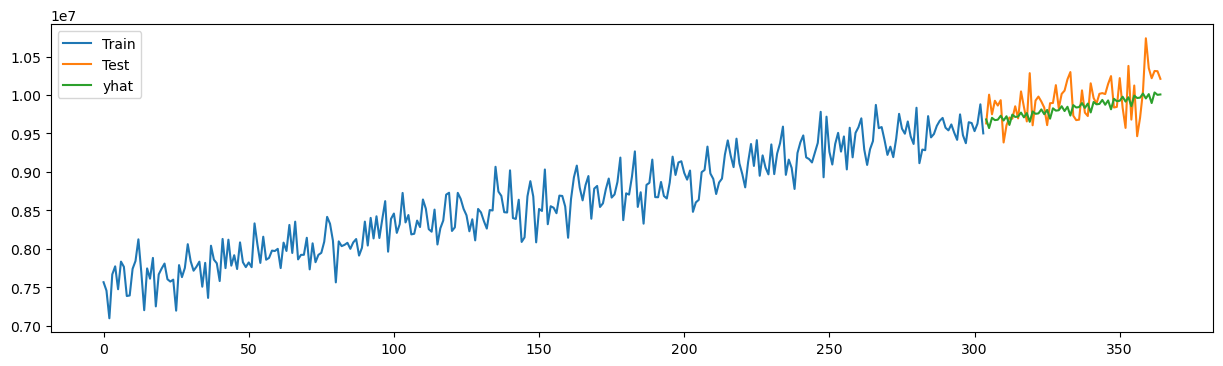

HW RMSE:  237634.82664590626


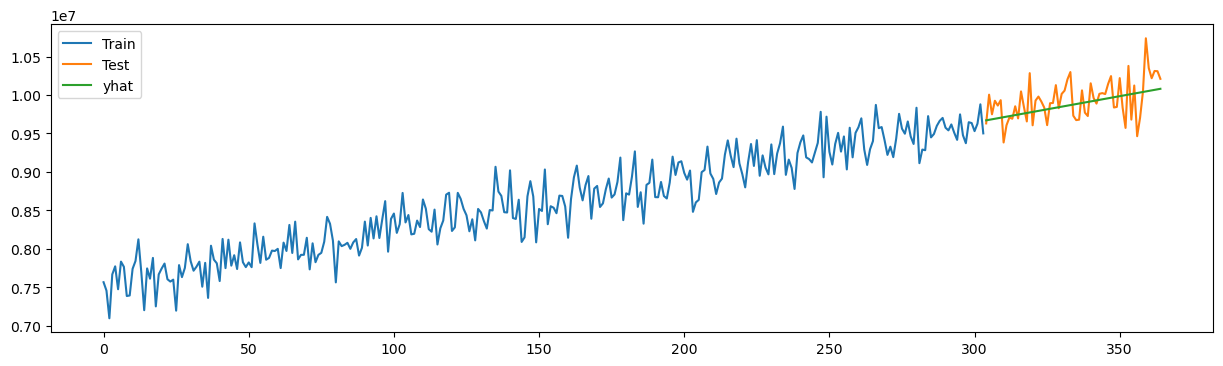

HW RMSE:  256728.9731688891


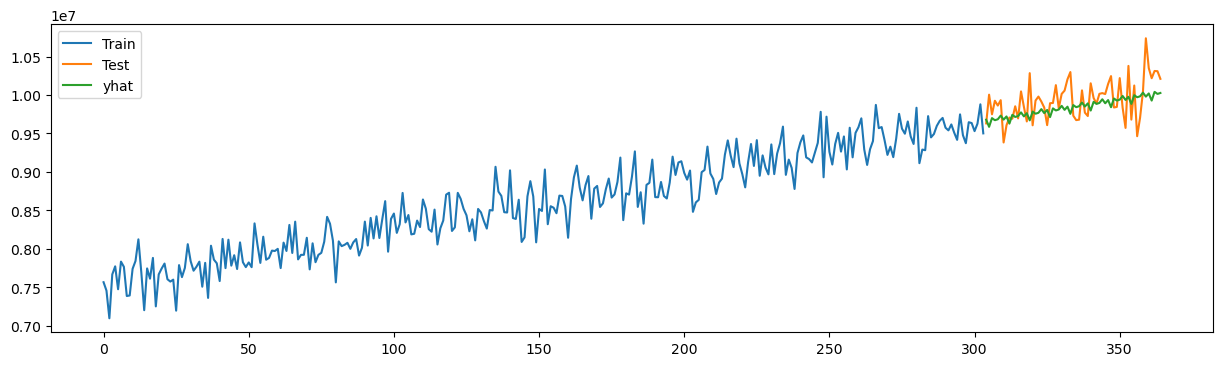

HW RMSE:  258707.24009030304


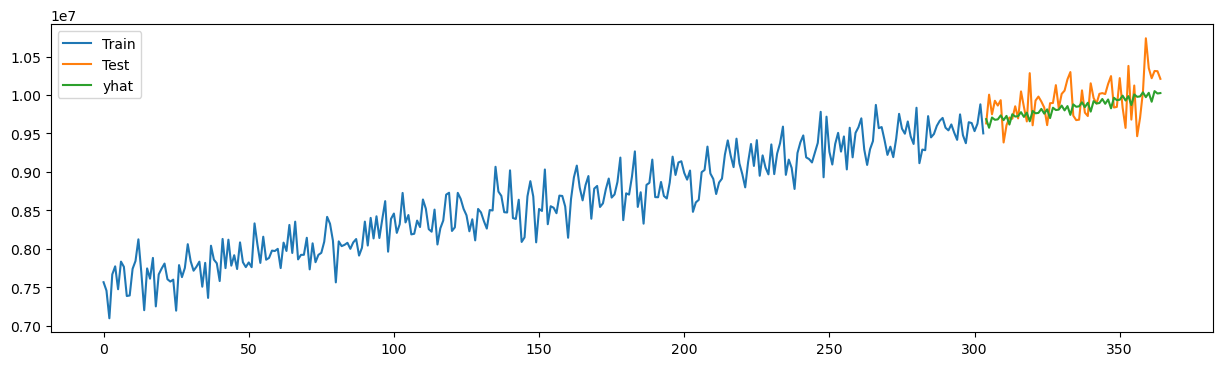

HW RMSE:  233683.43164149037


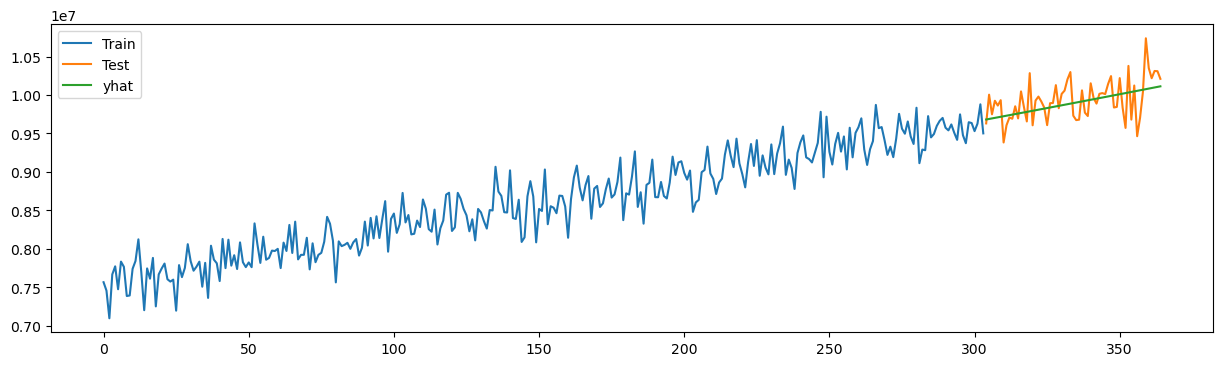

HW RMSE:  438302.5464547454


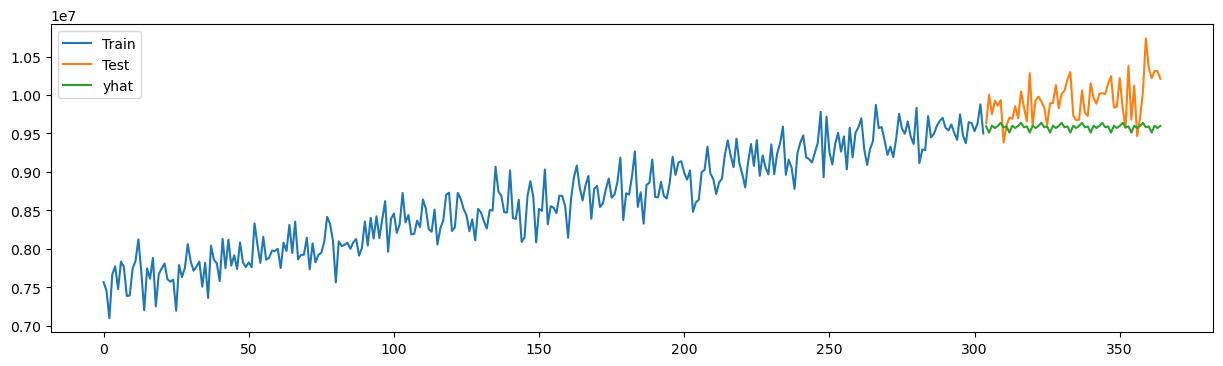

HW RMSE:  438854.985301343


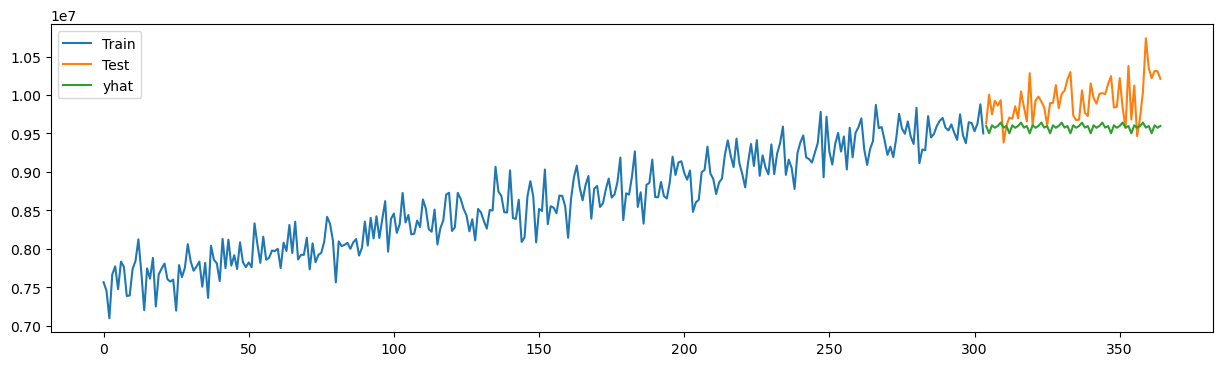

HW RMSE:  428077.9220318768


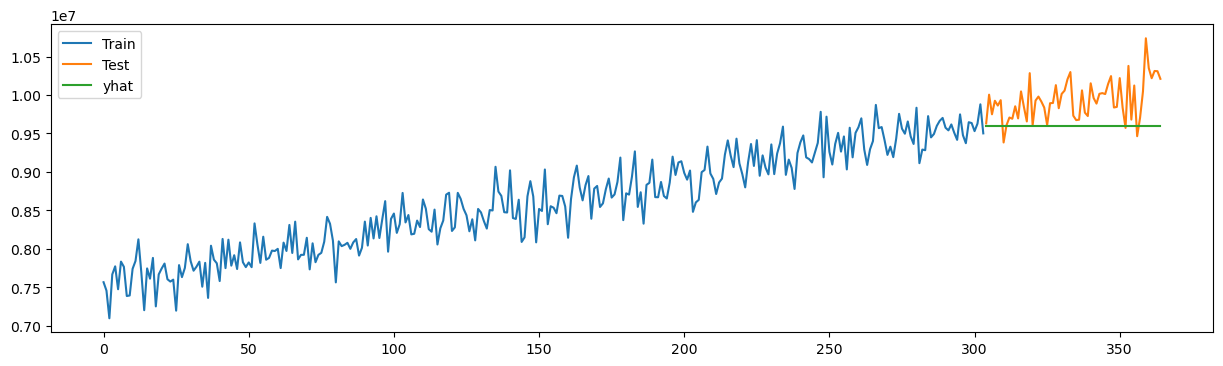

In [237]:
for i in range(2, 8):
    for method in ['add', 'mul', None]:
        for method2 in ['add', 'mul', None]:
            with mlflow.start_run():
                hw_model = ExponentialSmoothing(np.asarray(hw_train.receipt_count), seasonal_periods=i, trend=method, seasonal=method2).fit()
                hw_test['hw'] = hw_model.forecast(len(hw_test))

                # Calculate the RMSE
                hw_rmse = rmse(hw_test['receipt_count'], hw_test['hw'])
                print('HW RMSE: ', hw_rmse)

                params = {
                    'seasonal_periods': i,
                    'trend': method,
                    'seasonal': method2,
                }


                plot_predictions(hw_train, hw_test, hw_test, 'hw')

                # Log the RMSE
                mlflow.log_metric('rmse', hw_rmse)
                mlflow.log_params(params)
                mlflow.log_param('model', 'holt-winters-additive')
                mlflow.log_figure(fig, 'hw_model_additive_results.png')

HW RMSE:  260700.40764071673


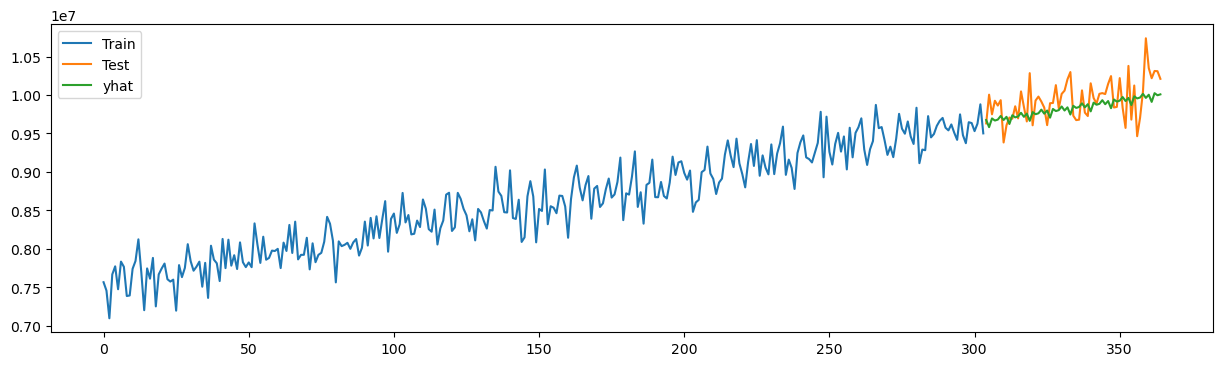

In [134]:
with mlflow.start_run():
    hw_model = ExponentialSmoothing(np.asarray(hw_train.receipt_count), seasonal_periods=7, trend='additive', seasonal='additive').fit()
    hw_test['hw'] = hw_model.forecast(len(hw_test))

    # Calculate the RMSE
    hw_rmse = rmse(hw_test['receipt_count'], hw_test['hw'])
    print('HW RMSE: ', hw_rmse)

    plot_predictions(hw_train, hw_test, hw_test, 'hw')

    # Log the RMSE
    mlflow.log_metric('rmse', hw_rmse)
    mlflow.log_param('model', 'holt-winters-additive')
    mlflow.log_figure(fig, 'hw_model_additive_results.png')

HW RMSE:  260662.40098148727


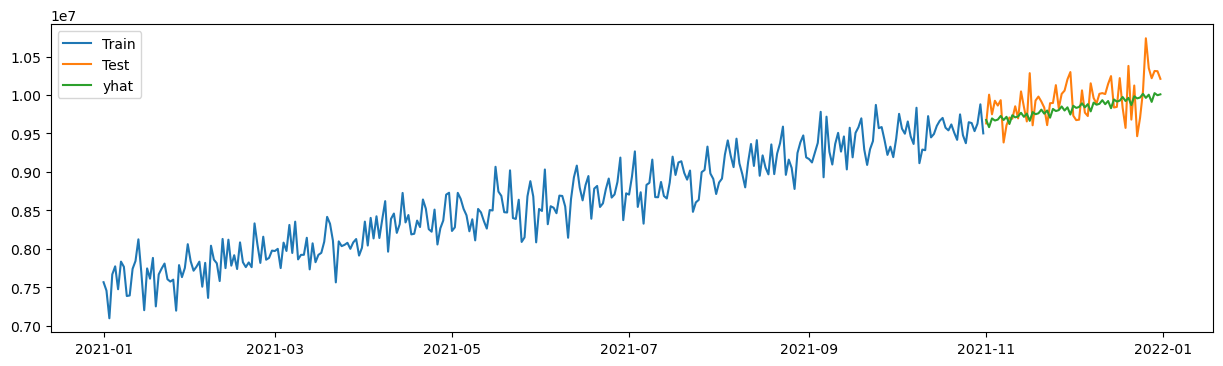

In [135]:
hw_train, hw_test = hw_train.set_index('date'), hw_test.set_index('date')

with mlflow.start_run():
    hw_model = ExponentialSmoothing(np.asarray(hw_train.receipt_count), seasonal_periods=7, trend='additive', seasonal='additive', use_boxcox=True).fit()
    hw_test['hw'] = hw_model.forecast(len(hw_test))

    # Calculate the RMSE
    hw_rmse = rmse(hw_test['receipt_count'], hw_test['hw'])
    print('HW RMSE: ', hw_rmse)

    plot_predictions(hw_train, hw_test, hw_test, 'hw')

    params = {
        'seasonal_periods': 7,
        'trend': 'additive',
        'seasonal': 'additive',
        'use_boxcox': True
    }

    # Log the RMSE
    mlflow.log_metric('rmse', hw_rmse)
    mlflow.log_param('model', 'holt-winters-additive')
    mlflow.log_params(params)
    mlflow.log_figure(fig, 'hw_model_additive_results.png')

In [ ]:
hw_train, hw_test = hw_train.set_index('date'), hw_test.set_index('date')

with mlflow.start_run():
    hw_model = ExponentialSmoothing(np.asarray(hw_train.receipt_count), seasonal_periods=7, trend='additive', seasonal='additive', use_boxcox=True).fit()
    hw_test['hw'] = hw_model.forecast(len(hw_test))

    # Calculate the RMSE
    hw_rmse = rmse(hw_test['receipt_count'], hw_test['hw'])
    print('HW RMSE: ', hw_rmse)

    plot_predictions(hw_train, hw_test, hw_test, 'hw')

    params = {
        'seasonal_periods': 7,
        'trend': 'additive',
        'seasonal': 'additive',
        'use_boxcox': True
    }

    # Log the RMSE
    mlflow.log_metric('rmse', hw_rmse)
    mlflow.log_param('model', 'holt-winters-additive')
    mlflow.log_params(params)
    mlflow.log_figure(fig, 'hw_model_additive_results.png')

HW RMSE:  280601.6451728688


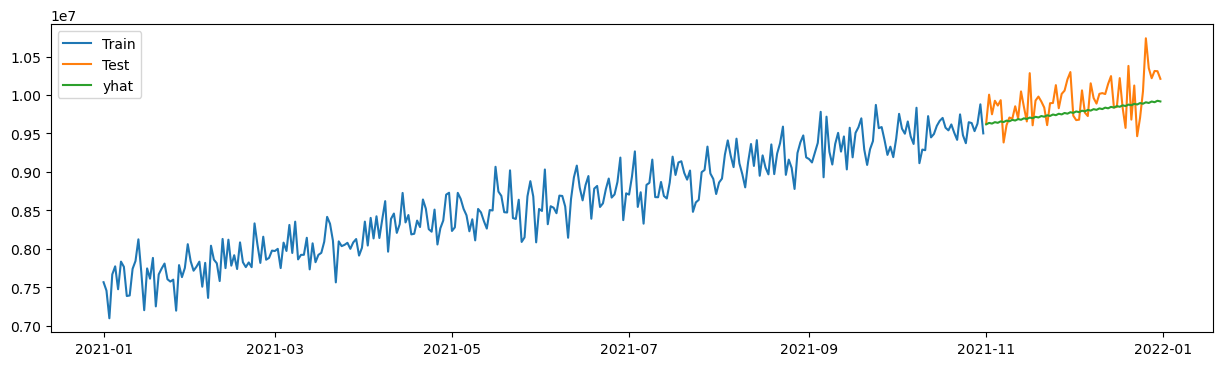

HW RMSE:  265291.44170626503


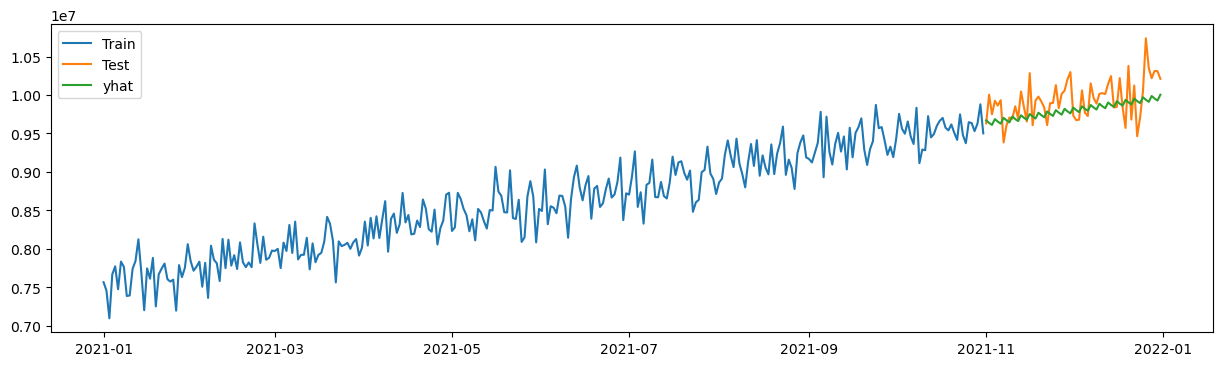

HW RMSE:  277428.32792699436


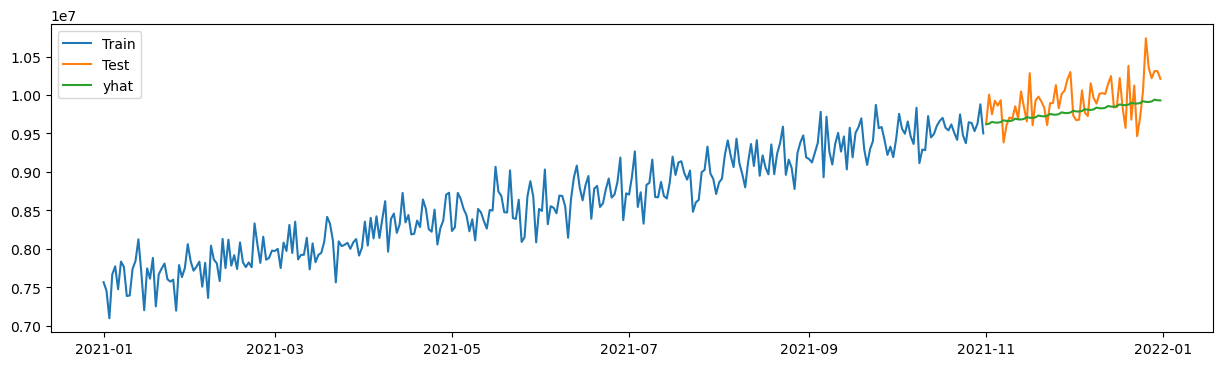

HW RMSE:  271961.3619674413


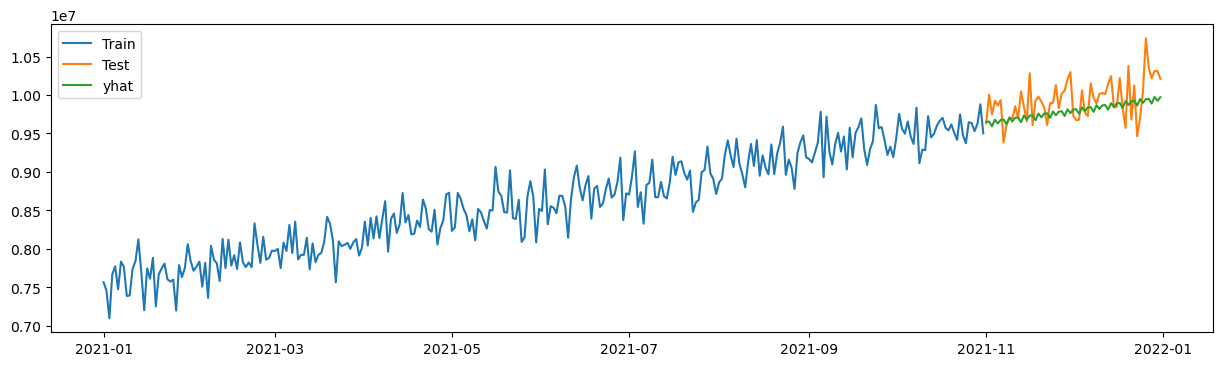

HW RMSE:  271593.6638437803


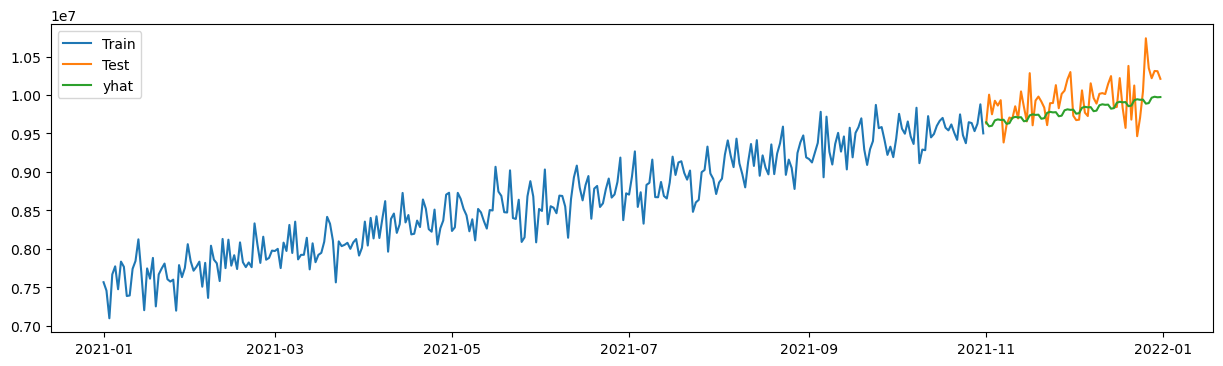

HW RMSE:  260662.40098148727


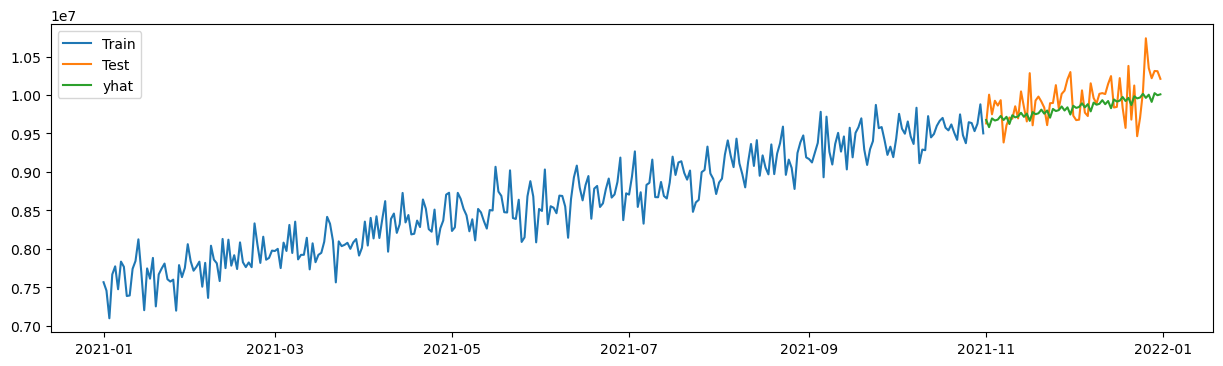

In [138]:
for i in range(2, 8):
    with mlflow.start_run():
        hw_model = ExponentialSmoothing(np.asarray(hw_train.receipt_count), seasonal_periods=i, trend='additive', seasonal='additive', use_boxcox=True).fit()
        hw_test['hw'] = hw_model.forecast(len(hw_test))

        # Calculate the RMSE
        hw_rmse = rmse(hw_test['receipt_count'], hw_test['hw'])
        print('HW RMSE: ', hw_rmse)

        plot_predictions(hw_train, hw_test, hw_test, 'hw')

        params = {
            'seasonal_periods': i,
            'trend': 'additive',
            'seasonal': 'additive',
            'use_boxcox': True
        }

        # Log the RMSE
        mlflow.log_metric('rmse', hw_rmse)
        mlflow.log_param('model', 'holt-winters-additive')
        mlflow.log_params(params)
        mlflow.log_figure(fig, 'hw_model_additive_results.png')

## ARIMA

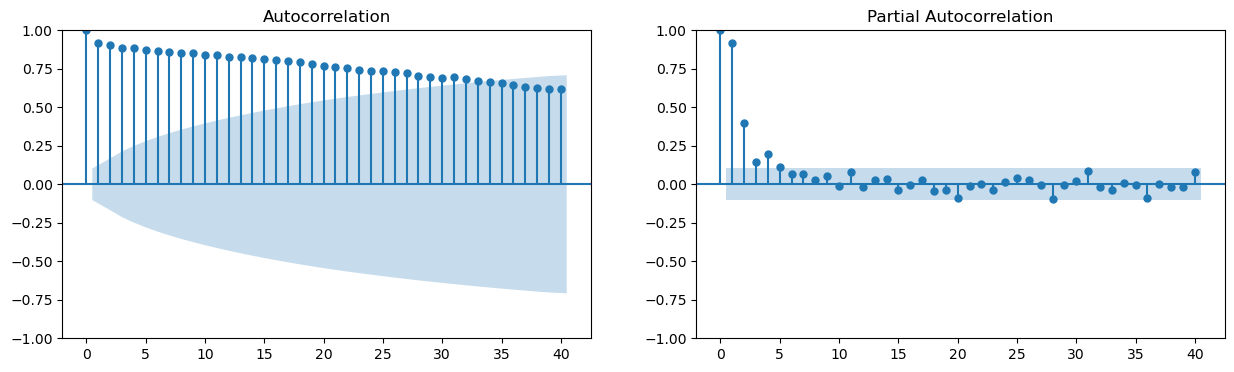

In [43]:
# ACF and PACF plots
fig, axes = plt.subplots(1,2,figsize=(15,4))
plot_acf(df.receipt_count, lags=40, ax=axes[0])
plot_pacf(df.receipt_count, lags=40, method='ywm', ax=axes[1])
plt.show()

In [ ]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'signif': signif, 'test_statistic': round(r[0], 4), 'pvalue': round(
        r[1], 4), 'n_lags': round(r[2], 4), 'n_obs': r[3]}
    p_value = output['pvalue']
    def adjust(val, length=6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key, val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')
        output[f' Critical value {adjust(key)}'] = round(val, 3)
    output['Column'] = name
    
    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(
            f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")
    res = pd.DataFrame(output, index=[name])
    # res.columns = ['Value']
    return res

In [ ]:
res = adfuller_test(df['receipt_count'], name='receipt_count')

    Augmented Dickey-Fuller Test on "receipt_count" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = 0.175
 No. Lags Chosen       = 17
 Critical value 1%     = -3.449
 Critical value 5%     = -2.87
 Critical value 10%    = -2.571
 => P-Value = 0.9708. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


In [ ]:
df_oneDiff = df['receipt_count'].diff().dropna()
res = adfuller_test(df_oneDiff, name='receipt_count')

    Augmented Dickey-Fuller Test on "receipt_count" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -8.8898
 No. Lags Chosen       = 17
 Critical value 1%     = -3.449
 Critical value 5%     = -2.87
 Critical value 10%    = -2.571
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


In [139]:
arima_train, arima_test = split_data(df)
arima_train, arima_test = arima_train.set_index('date'), arima_test.set_index('date')

In [141]:
model = auto_arima(arima_train.receipt_count, start_p=1, start_q=1, d=None, max_p=12, max_q=12, max_d=4, start_P=0, start_Q=0, D=0, max_P=0, max_Q=0, max_D=0, m=0, seasonal=False, \
           trace=True, error_action='warn', suppress_warnings=True, random_state = 42, n_fits=40, n_jobs=-1)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=8491.739, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=8504.560, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8485.054, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=8491.030, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=8502.700, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=8485.477, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=8495.630, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=8483.555, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=8484.181, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=8490.063, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=8489.415, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=8494.145, Time=0.12 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.723 seconds


In [142]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  304
Model:               SARIMAX(1, 1, 0)   Log Likelihood               -4239.777
Date:                Wed, 18 Oct 2023   AIC                           8483.555
Time:                        19:01:08   BIC                           8490.982
Sample:                    01-01-2021   HQIC                          8486.526
                         - 10-31-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1611      0.008    -19.688      0.000      -0.177      -0.145
sigma2      6.982e+10   6.74e-15   1.04e+25      0.000    6.98e+10    6.98e+10
===================================================================================
Ljung-Box (L1) (Q):                  40.27   Jarque-Bera (JB):                 0.60
Prob(Q):                              0.00   Prob(JB):                         0.74
Heteroskedasticity (H):               0.81   Skew:                            -0.06
Prob(H) (two-sided):                  0.29   Kurtosis:                         3.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.19e+40. Standard errors may be unstable.
"""

In [143]:
yhat = model.predict(n_periods=61)
rmse(arima_test.receipt_count, yhat)

459286.9772440152

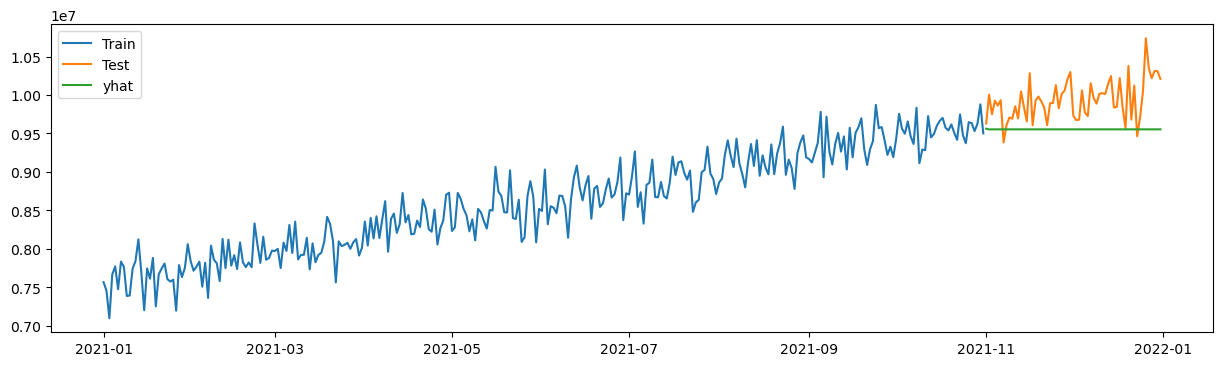

In [147]:
fig = plt.figure(figsize=(15,4))
plt.plot(arima_train.receipt_count, label='Train')
plt.plot(arima_test.receipt_count, label='Test')
plt.plot(pd.Series(yhat, index=arima_test.index), label='yhat')
plt.legend(loc='best')
plt.show()

In [148]:
mlflow.set_experiment('ARIMA-models')

2023/10/18 19:07:08 INFO mlflow.tracking.fluent: Experiment with name 'ARIMA-models' does not exist. Creating a new experiment.


<Experiment: artifact_location='/Users/wizard/Astronaut/Assesments/Fetch_Rewards/notebooks/mlruns/3', creation_time=1697670428676, experiment_id='3', last_update_time=1697670428676, lifecycle_stage='active', name='ARIMA-models', tags={}>

In [149]:
with mlflow.start_run():
    params = {
        'p': 1,
        'd': 1,
        'q': 0
    }
    mlflow.log_metric('rmse', rmse(arima_test.receipt_count, yhat))
    mlflow.log_param('model', 'auto-arima')
    mlflow.log_params(params)
    mlflow.log_figure(fig, 'auto-arima-results.png')

## SARIMA Model

In [150]:
model = auto_arima(arima_train.receipt_count, start_p=1, start_q=1, d=None, max_p=12, max_q=12, max_d=4, start_P=1, start_Q=1, D=None, max_P=12, max_Q=12, max_D=2, m=7, seasonal=True, \
           trace=True, error_action='warn', suppress_warnings=True, random_state = 42, n_fits=40, n_jobs=-1)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[7] intercept   : AIC=inf, Time=0.43 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=8504.560, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=8486.996, Time=0.06 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=8492.931, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=8502.700, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=8485.054, Time=0.03 sec
 ARIMA(1,1,0)(0,0,1)[7] intercept   : AIC=8486.988, Time=0.06 sec
 ARIMA(1,1,0)(1,0,1)[7] intercept   : AIC=8488.206, Time=0.26 sec
 ARIMA(2,1,0)(0,0,0)[7] intercept   : AIC=8485.477, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[7] intercept   : AIC=8491.739, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=8491.030, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[7] intercept   : AIC=8495.630, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[7]             : AIC=8483.555, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[7]             : AIC=8485.513, Time=0.09 sec
 ARIMA(1,1,0)(0,0,1)[7]             : 

In [151]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  304
Model:               SARIMAX(1, 1, 0)   Log Likelihood               -4239.777
Date:                Wed, 18 Oct 2023   AIC                           8483.555
Time:                        19:09:24   BIC                           8490.982
Sample:                    01-01-2021   HQIC                          8486.526
                         - 10-31-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1611      0.008    -19.688      0.000      -0.177      -0.145
sigma2      6.982e+10   6.74e-15   1.04e+25      0.000    6.98e+10    6.98e+10
===================================================================================
Ljung-Box (L1) (Q):                  40.27   Jarque-Bera (JB):                 0.60
Prob(Q):                              0.00   Prob(JB):                         0.74
Heteroskedasticity (H):               0.81   Skew:                            -0.06
Prob(H) (two-sided):                  0.29   Kurtosis:                         3.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.19e+40. Standard errors may be unstable.
"""

In [152]:
yhat = model.predict(n_periods=61)
rmse(arima_test.receipt_count, yhat)

459286.9772440152

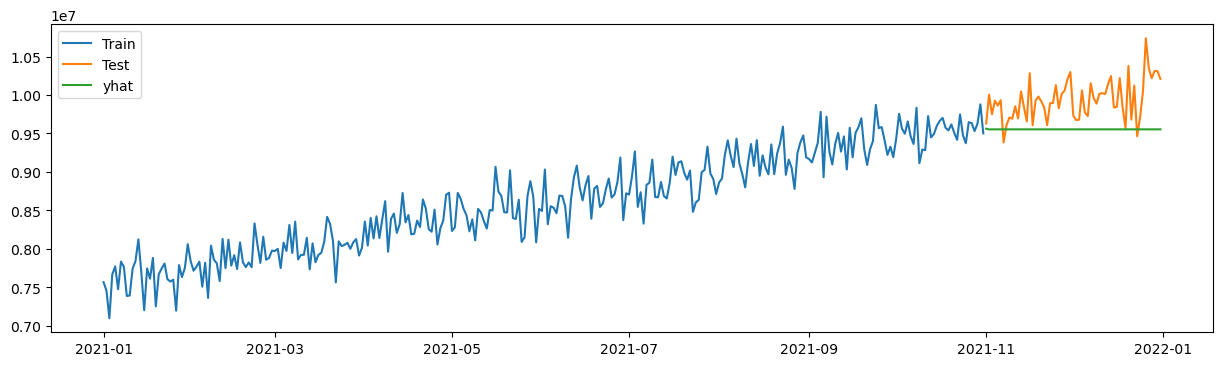

In [153]:
fig = plt.figure(figsize=(15,4))
plt.plot(arima_train.receipt_count, label='Train')
plt.plot(arima_test.receipt_count, label='Test')
plt.plot(pd.Series(yhat, index=arima_test.index), label='yhat')
plt.legend(loc='best')
plt.show()

In [154]:
with mlflow.start_run():
    params = {
        'p': 1,
        'd': 1,
        'q': 0,
        'P': 0,
        'D': 0,
        'Q': 0,
        'm': 7
    }
    mlflow.log_metric('rmse', rmse(arima_test.receipt_count, yhat))
    mlflow.log_param('model', 'sarima')
    mlflow.log_params(params)
    mlflow.log_figure(fig, 'sarima-results.png')

In [156]:
model = auto_arima(arima_train.receipt_count, start_p=1, start_q=1, d=None, max_p=12, max_q=12, max_d=4, start_P=1, start_Q=1, D=None, max_P=12, max_Q=12, max_D=2, m=12, seasonal=True, \
           trace=True, error_action='warn', suppress_warnings=True, random_state = 42, n_fits=40, n_jobs=-1)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=8495.268, Time=0.35 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=8504.560, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=8486.900, Time=0.08 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=8492.937, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=8502.700, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=8485.054, Time=0.03 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=8486.897, Time=0.07 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=8488.903, Time=0.09 sec
 ARIMA(2,1,0)(0,0,0)[12] intercept   : AIC=8485.477, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=8491.739, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=8491.030, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[12] intercept   : AIC=8495.630, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=8483.555, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=8485.370, Time=0.09 sec
 ARIMA(1,1,0)(0,0,1

## Prophet

In [159]:
prophet_train, prophet_test = split_data(df)

In [160]:
prophet_train['date'] = pd.to_datetime(prophet_train['date'], format='%Y-%m-%d')
prophet_test['date'] = pd.to_datetime(prophet_test['date'], format='%Y-%m-%d')
prophet_train.columns = ['ds', 'y']
prophet_test.columns = ['ds', 'y']

In [161]:
prophet_train.head()

ds        y
0 2021-01-01  7564766
1 2021-01-02  7455524
2 2021-01-03  7095414
3 2021-01-04  7666163
4 2021-01-05  7771289

In [163]:
model = Prophet()
model.fit(prophet_train)
future = model.make_future_dataframe(periods=61)
forecast = model.predict(future)

INFO  [prophet] Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO  [prophet] Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


DEBUG [cmdstanpy] input tempfile: /var/folders/62/z8lwyqfj0gx7nx1vv3g2sd1w0000gn/T/tmpmeq69eww/xf5niqw8.json
DEBUG [cmdstanpy] input tempfile: /var/folders/62/z8lwyqfj0gx7nx1vv3g2sd1w0000gn/T/tmpmeq69eww/u5t22jxx.json
DEBUG [cmdstanpy] idx 0
DEBUG [cmdstanpy] running CmdStan, num_threads: None
DEBUG [cmdstanpy] CmdStan args: ['/Users/wizard/anaconda3/lib/python3.9/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79565', 'data', 'file=/var/folders/62/z8lwyqfj0gx7nx1vv3g2sd1w0000gn/T/tmpmeq69eww/xf5niqw8.json', 'init=/var/folders/62/z8lwyqfj0gx7nx1vv3g2sd1w0000gn/T/tmpmeq69eww/u5t22jxx.json', 'output', 'file=/var/folders/62/z8lwyqfj0gx7nx1vv3g2sd1w0000gn/T/tmpmeq69eww/prophet_modelg969mm15/prophet_model-20231018191903.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:19:03 - cmdstanpy - INFO - Chain [1] start processing
INFO  [cmdstanpy] Chain [1] start processing
19:19:04 - cmdstanpy - INFO - Chain [1] done processing
INFO  [cmdstanpy] Chain [1] done proce

In [166]:
forecast.shape

(365, 16)

In [167]:
rmse(prophet_test.y, forecast.yhat[-61:]) 

244881.97555561826

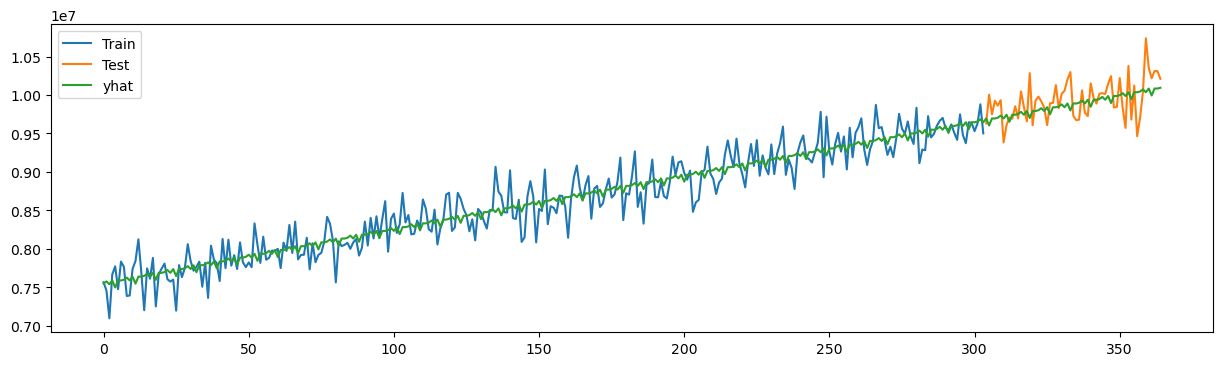

In [168]:
fig = plt.figure(figsize=(15,4))
plt.plot(prophet_train.y, label='Train')
plt.plot(prophet_test.y, label='Test')
plt.plot(forecast.yhat, label='yhat')
plt.legend(loc='best')
plt.show()

In [169]:
mlflow.set_experiment('prophet-models')

2023/10/18 19:21:00 INFO mlflow.tracking.fluent: Experiment with name 'prophet-models' does not exist. Creating a new experiment.


<Experiment: artifact_location='/Users/wizard/Astronaut/Assesments/Fetch_Rewards/notebooks/mlruns/4', creation_time=1697671260494, experiment_id='4', last_update_time=1697671260494, lifecycle_stage='active', name='prophet-models', tags={}>

In [172]:
with mlflow.start_run():
    mlflow.log_metric('rmse', rmse(prophet_test.y, forecast.yhat[-61:]))
    mlflow.log_param('model', 'prophet')
    mlflow.log_figure(fig, 'prophet-results.png')

INFO  [prophet] Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO  [prophet] Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG [cmdstanpy] input tempfile: /var/folders/62/z8lwyqfj0gx7nx1vv3g2sd1w0000gn/T/tmpmeq69eww/lot84pwk.json
DEBUG [cmdstanpy] input tempfile: /var/folders/62/z8lwyqfj0gx7nx1vv3g2sd1w0000gn/T/tmpmeq69eww/2_zjt_0g.json
DEBUG [cmdstanpy] idx 0
DEBUG [cmdstanpy] running CmdStan, num_threads: None
DEBUG [cmdstanpy] CmdStan args: ['/Users/wizard/anaconda3/lib/python3.9/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78755', 'data', 'file=/var/folders/62/z8lwyqfj0gx7nx1vv3g2sd1w0000gn/T/tmpmeq69eww/lot84pwk.json', 'init=/var/folders/62/z8lwyqfj0gx7nx1vv3g2sd1w0000gn/T/tmpmeq69eww/2_zjt_0g.json', 'output', 'file=/var/folders/62/z8lwyqfj0gx7nx1vv3g2sd1w0000gn/T/tmpmeq69eww/prophet_model000ygkgy/prophet_model-20231018193505.csv', 'method=optimize', 'algorithm=lbfgs', 'i

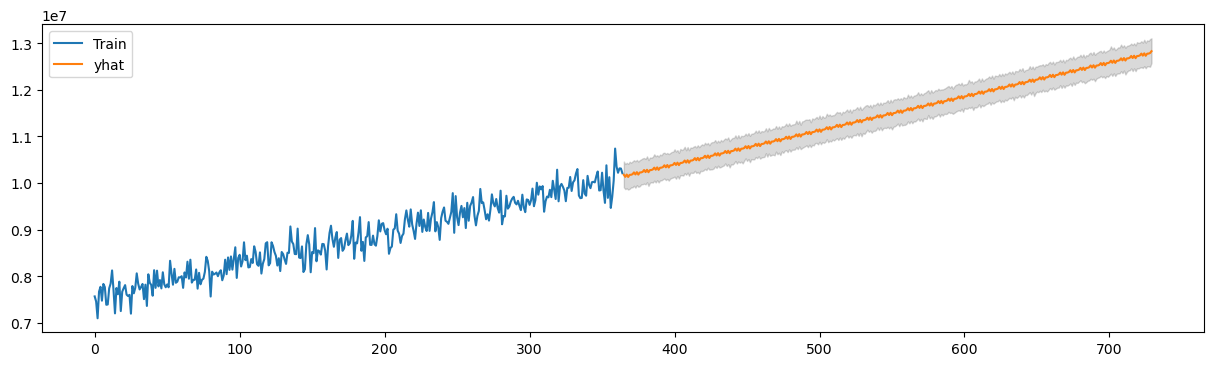

In [180]:
prophet_df = df.copy()

prophet_df.date = pd.to_datetime(prophet_df.date, format='%Y-%m-%d')
prophet_df.columns = ['ds', 'y']

model = Prophet()
model.fit(prophet_df)
future = model.make_future_dataframe(periods=365)
forecast = model.predict(future)

fig = plt.figure(figsize=(15,4))
plt.plot(prophet_df.y, label='Train')
plt.plot(forecast.yhat[-365:], label='yhat')
plt.fill_between(forecast.index[-365:], forecast.yhat_lower[-365:], forecast.yhat_upper[-365:], color='k', alpha=.15)
plt.legend(loc='best')
plt.show()

In [181]:
forecast.head()

ds         trend    yhat_lower    yhat_upper   trend_lower  \
0 2021-01-01  7.536299e+06  7.262495e+06  7.797253e+06  7.536299e+06   
1 2021-01-02  7.543392e+06  7.316557e+06  7.856812e+06  7.543392e+06   
2 2021-01-03  7.550485e+06  7.259346e+06  7.791626e+06  7.550485e+06   
3 2021-01-04  7.557578e+06  7.285990e+06  7.842689e+06  7.557578e+06   
4 2021-01-05  7.564671e+06  7.270825e+06  7.814010e+06  7.564671e+06   

    trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
0  7.536299e+06     1102.282211           1102.282211           1102.282211   
1  7.543392e+06    32906.634617          32906.634617          32906.634617   
2  7.550485e+06   -18564.517318         -18564.517318         -18564.517318   
3  7.557578e+06    23085.068160          23085.068160          23085.068160   
4  7.564671e+06   -36450.139994         -36450.139994         -36450.139994   

         weekly  weekly_lower  weekly_upper  multiplicative_terms  \
0   1102.282211   1102.282211   1102.282211                   0.0   
1  32906.634617  32906.634617  32906.634617                   0.0   
2 -18564.517318 -18564.517318 -18564.517318                   0.0   
3  23085.068160  23085.068160  23085.068160                   0.0   
4 -36450.139994 -36450.139994 -36450.139994                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper          yhat  
0                         0.0                         0.0  7.537401e+06  
1                         0.0                         0.0  7.576299e+06  
2                         0.0                         0.0  7.531920e+06  
3                         0.0                         0.0  7.580663e+06  
4                         0.0                         0.0  7.528221e+06

In [222]:
# Group by month on forecast
forecast['month'] = forecast['ds'].dt.month
forecast['year'] = forecast['ds'].dt.year

# Get the sum forecast by month
yhat_2022 = forecast[forecast.year == 2022].groupby('month')['yhat'].sum().reset_index()
yhat_2022['upper_bound'] = forecast[forecast.year == 2022].groupby('month')['yhat_upper'].sum().reset_index().yhat_upper
yhat_2022['lower_bound'] = forecast[forecast.year == 2022].groupby('month')['yhat_lower'].sum().reset_index().yhat_lower

In [186]:
prophet_df['month'] = prophet_df.ds.dt.month
y_2021 = prophet_df.groupby('month')['y'].sum().reset_index()

In [206]:
start = "2021-01-01"
end = "2023-1-01"

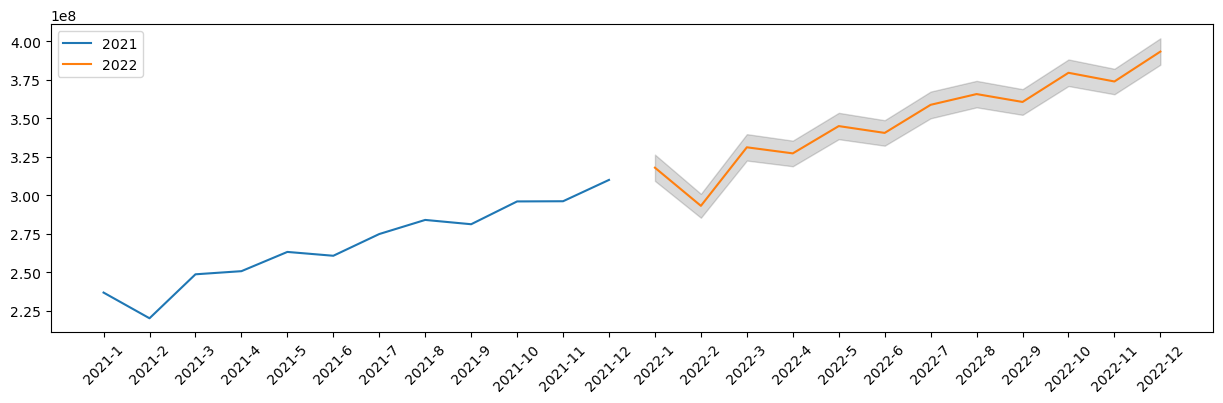

In [233]:
result = pd.DataFrame({
    'ds': pd.date_range(start, end, freq='M'),
    'y': list(y_2021['y'].values) + [np.nan] * 12, 
    'yhat': [np.nan] * 12 + list(yhat_2022['yhat'].values), 
    'yhat_upper': [np.nan] * 12 + list(yhat_2022['upper_bound'].values),
    'yhat_lower': [np.nan] * 12 + list(yhat_2022['lower_bound'].values)
})
plt.figure(figsize=(15,4))
plt.plot(result['y'],  label='2021')
plt.plot(result['yhat'], label='2022')
plt.fill_between(result.index[-12:], result.yhat_lower[-12:], result.yhat_upper[-12:], color='k', alpha=.15)
plt.xticks(range(0,24), [str(dt.year) + '-' + str(dt.month) for dt in result.ds.dt.date], rotation=45)
plt.legend()
plt.show()

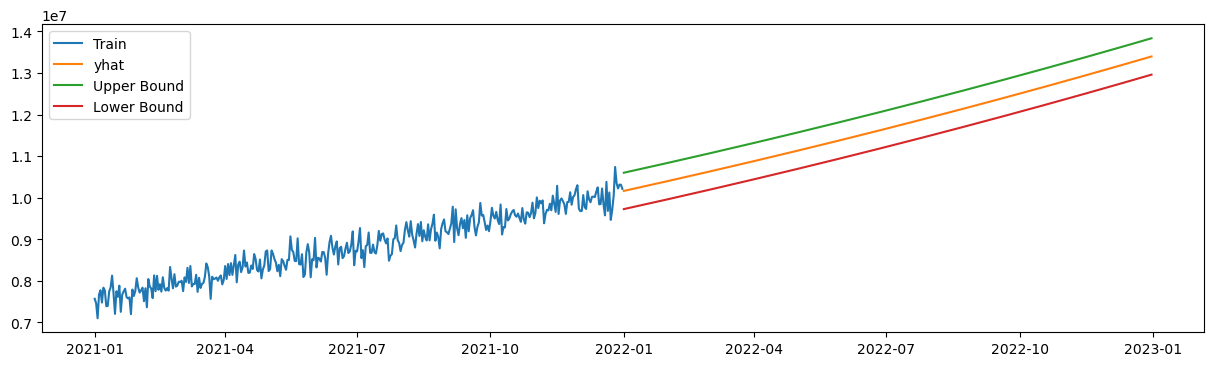

In [305]:
hw_df = df.copy()

start = "2021-01-01"
end = "2022-12-31"

hw_model = ExponentialSmoothing(np.asarray(hw_df.receipt_count), seasonal_periods=7, trend="mul").fit()
yhat = hw_model.forecast(365)

residuals = hw_df.receipt_count - hw_model.fittedvalues

# Compute the prediction intervals
alpha = 0.05  # for a 95% confidence interval
z = abs(np.percentile(np.random.standard_normal(10000), [100 * alpha/2, 100 * (1 - alpha/2)]))
std_residual = residuals.std()
interval_upper = yhat + z[1] * std_residual * np.sqrt(1 + 1/len(hw_df))
interval_lower = yhat - z[1] * std_residual * np.sqrt(1 + 1/len(hw_df))

result = pd.DataFrame({
    'ds': pd.date_range(start, end, freq='D'),
    'y': list(hw_df.receipt_count.values) + [np.nan] * 365, 
    'yhat': [np.nan] * 365 + list(yhat),
    'upper_bound': [np.nan] * 365 + list(interval_upper),
    'lower_bound': [np.nan] * 365 + list(interval_lower)
})

result['year'] = result.ds.dt.year
result['month'] = result.ds.dt.month

fig = plt.figure(figsize=(15,4))
plt.plot(result.ds, result.y, label='Train')
plt.plot(result.ds, result.yhat, label='yhat')
plt.plot(result.ds, result.upper_bound, label='Upper Bound')
plt.plot(result.ds, result.lower_bound, label='Lower Bound')
plt.legend(loc='best')
plt.show()

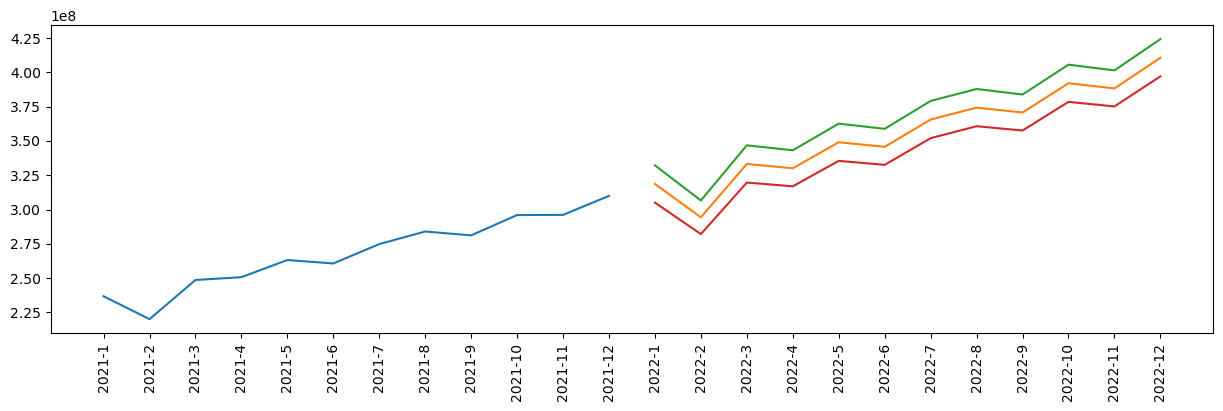

In [306]:
result = result.groupby(['year', 'month']).sum().reset_index()
result['monthly'] = result['year'].astype(str) + '-' + result['month'].astype(str)
result['y'].iloc[-12:] = np.nan
result['yhat'].iloc[:12] = np.nan
result['upper_bound'].iloc[:12] = np.nan
result['lower_bound'].iloc[:12] = np.nan

plt.figure(figsize=(15,4))
plt.plot(result.monthly, result.y, label='Train')
plt.plot(result.monthly, result.yhat, label='yhat')
plt.plot(result.monthly, result.upper_bound, label='Upper Bound')
plt.plot(result.monthly, result.lower_bound, label='Lower Bound')
plt.xticks(rotation=90)
plt.show()

In [307]:
import pickle

with open('../deployment/models/hw_model.pkl', 'wb') as f:
    pickle.dump(hw_model, f)

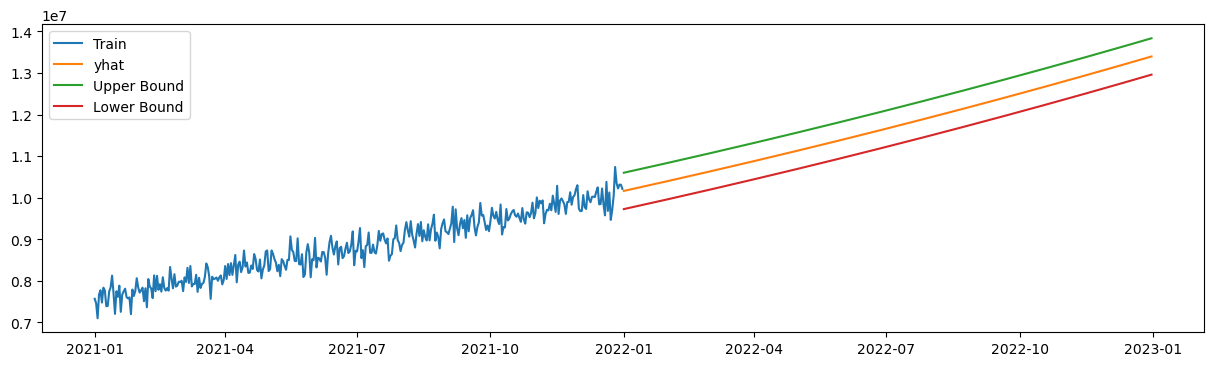

In [ ]:
hw_df = df.copy()

start = "2021-01-01"
end = "2022-12-31"

hw_model = ExponentialSmoothing(np.asarray(hw_df.receipt_count), seasonal_periods=7, trend="mul").fit()
yhat = hw_model.forecast(365)

residuals = hw_df.receipt_count - hw_model.fittedvalues

# Compute the prediction intervals
alpha = 0.05  # for a 95% confidence interval
z = abs(np.percentile(np.random.standard_normal(10000), [100 * alpha/2, 100 * (1 - alpha/2)]))
std_residual = residuals.std()
interval_upper = yhat + z[1] * std_residual * np.sqrt(1 + 1/len(hw_df))
interval_lower = yhat - z[1] * std_residual * np.sqrt(1 + 1/len(hw_df))

result = pd.DataFrame({
    'ds': pd.date_range(start, end, freq='D'),
    'y': list(hw_df.receipt_count.values) + [np.nan] * 365, 
    'yhat': [np.nan] * 365 + list(yhat),
    'upper_bound': [np.nan] * 365 + list(interval_upper),
    'lower_bound': [np.nan] * 365 + list(interval_lower)
})

result['year'] = result.ds.dt.year
result['month'] = result.ds.dt.month

fig = plt.figure(figsize=(15,4))
plt.plot(result.ds, result.y, label='Train')
plt.plot(result.ds, result.yhat, label='yhat')
plt.plot(result.ds, result.upper_bound, label='Upper Bound')
plt.plot(result.ds, result.lower_bound, label='Lower Bound')
plt.legend(loc='best')
plt.show()

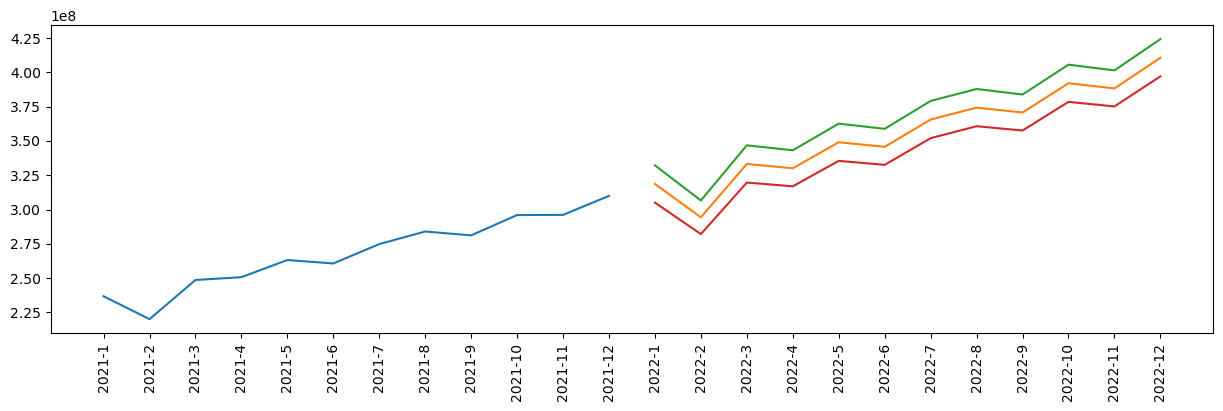

In [ ]:
result = result.groupby(['year', 'month']).sum().reset_index()
result['monthly'] = result['year'].astype(str) + '-' + result['month'].astype(str)
result['y'].iloc[-12:] = np.nan
result['yhat'].iloc[:12] = np.nan
result['upper_bound'].iloc[:12] = np.nan
result['lower_bound'].iloc[:12] = np.nan

plt.figure(figsize=(15,4))
plt.plot(result.monthly, result.y, label='Train')
plt.plot(result.monthly, result.yhat, label='yhat')
plt.plot(result.monthly, result.upper_bound, label='Upper Bound')
plt.plot(result.monthly, result.lower_bound, label='Lower Bound')
plt.xticks(rotation=90)
plt.show()

        date  receipt_count
0 2021-01-01        7564766
1 2021-01-02        7455524
2 2021-01-03        7095414
3 2021-01-04        7666163
4 2021-01-05        7771289
          ds          y  yhat  upper_bound  lower_bound  year  month
0 2021-01-01  7564766.0   NaN          NaN          NaN  2021      1
1 2021-01-02  7455524.0   NaN          NaN          NaN  2021      1
2 2021-01-03  7095414.0   NaN          NaN          NaN  2021      1
3 2021-01-04  7666163.0   NaN          NaN          NaN  2021      1
4 2021-01-05  7771289.0   NaN          NaN          NaN  2021      1


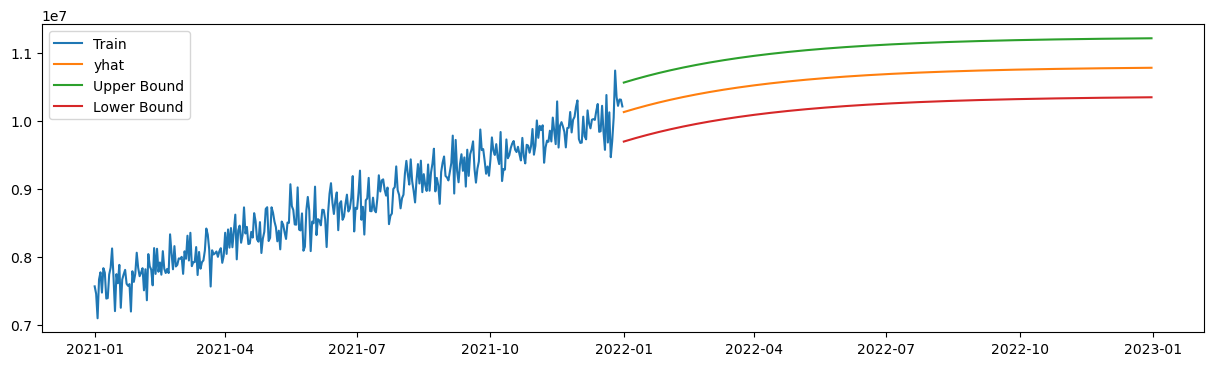

In [303]:
hw_df = df.copy()
print(hw_df.head())
start = "2021-01-01"
end = "2022-12-31"

hw_model = ExponentialSmoothing(np.asarray(hw_df.receipt_count), seasonal_periods=7, trend="mul", damped_trend=True).fit()
yhat = hw_model.forecast(365)

residuals = hw_df.receipt_count - hw_model.fittedvalues

# Compute the prediction intervals
alpha = 0.05  # for a 95% confidence interval
z = abs(np.percentile(np.random.standard_normal(10000), [100 * alpha/2, 100 * (1 - alpha/2)]))
std_residual = residuals.std()
interval_upper = yhat + z[1] * std_residual * np.sqrt(1 + 1/len(hw_df))
interval_lower = yhat - z[1] * std_residual * np.sqrt(1 + 1/len(hw_df))

result = pd.DataFrame({
    'ds': pd.date_range(start, end, freq='D'),
    'y': list(hw_df.receipt_count.values) + [np.nan] * 365, 
    'yhat': [np.nan] * 365 + list(yhat),
    'upper_bound': [np.nan] * 365 + list(interval_upper),
    'lower_bound': [np.nan] * 365 + list(interval_lower)
})

result['year'] = result.ds.dt.year
result['month'] = result.ds.dt.month

print(result.head())

fig = plt.figure(figsize=(15,4))
plt.plot(result.ds, result.y, label='Train')
plt.plot(result.ds, result.yhat, label='yhat')
plt.plot(result.ds, result.upper_bound, label='Upper Bound')
plt.plot(result.ds, result.lower_bound, label='Lower Bound')
plt.legend(loc='best')
plt.show()

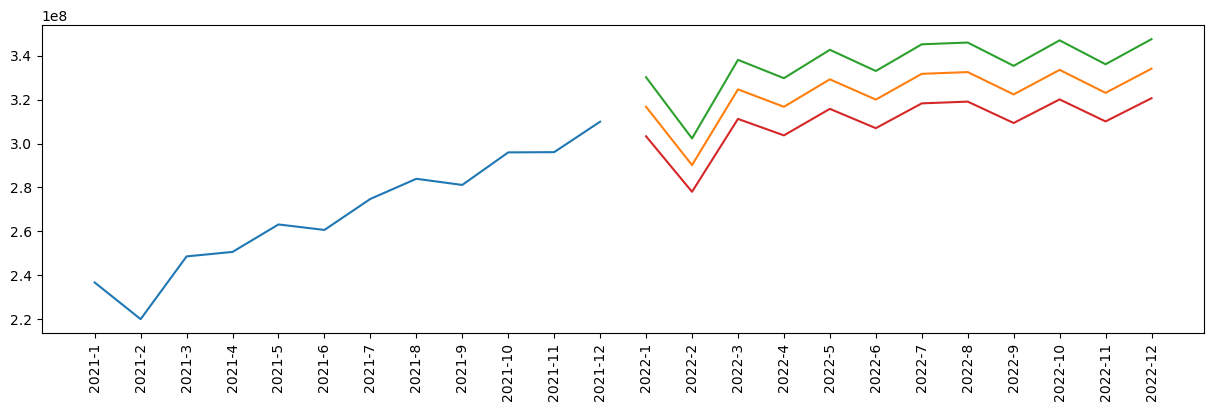

In [304]:
result = result.groupby(['year', 'month']).sum().reset_index()
result['monthly'] = result['year'].astype(str) + '-' + result['month'].astype(str)
result['y'].iloc[-12:] = np.nan
result['yhat'].iloc[:12] = np.nan
result['upper_bound'].iloc[:12] = np.nan
result['lower_bound'].iloc[:12] = np.nan

plt.figure(figsize=(15,4))
plt.plot(result.monthly, result.y, label='Train')
plt.plot(result.monthly, result.yhat, label='yhat')
plt.plot(result.monthly, result.upper_bound, label='Upper Bound')
plt.plot(result.monthly, result.lower_bound, label='Lower Bound')
plt.xticks(rotation=90)
plt.show()

In [299]:
import pickle

with open('../deployment/models/hw_model.pkl', 'wb') as f:
    pickle.dump(hw_model, f)